# Hands-on on Lattice Calculation in Python

*D. Gamba, A. Latina, A. Poyet, G. Sterbini, V. Ziemann*

[Introduction to Accelerator Physics, 18 September 1 October 2022, Kaunas, Lithuania](https://indico.cern.ch/event/1117526/)

<p align="center">
<img src=./_img_exercises/upload_ccbdd4fe3ac855ffa79715fb09caac24.png width="80%">
</p>

## Introduction 

In this document we will present the suggested directions to solve the exercises of the "*Hands-on Lattice Calculations in Python*".
 
These solutions are a natural complement to the ["*Transverse Linear Beam Dynamics Primer using Python*"](./CAS_Optics_Primer.pdf) and will serve as a guidance for the student. Most of the time the result can be achieved using multiple paths and we encourage the student to explore them. 

**In addition, the goal is to stimulate the student's curiosity, so the simple exercise should be challenged to trigger more questions and to dive deeper into the physics of the problem.**

## Is your computer ready?

You received the [instructions](./Setup_Instructions.md) on how to prepare your python working environment.

**QUESTION: is everyone able to launch a jupyter lab server from her/his laptop?** 

**QUESTION: can you import the following packages without errors?** 


In [1]:
# numpy: our main numerical package
import numpy as np
# matplotlib and seaborn: our plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# linear algebra and optimisation algorithms
from numpy.linalg import norm
from scipy.optimize import minimize
# some useful package
from copy import deepcopy

# **Optional:** for animations you might need to configure your jupyter lab properly:
# > pip install ipywidgets
# > jupyter nbextension enable --py widgetsnbextension
# > jupyter labextension install @jupyter-widgets/jupyterlab-manager
from ipywidgets import interactive

### ... some other setup not to be bothered later

Let's also configure `matplotlib` for more presentation-friendly plot production

In [2]:
# some setup for the plotting
from matplotlib import pyplot as plt
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## The physics basis

From [Wolfgan's lecture](https://indico.cern.ch/event/1117526/contributions/4978192/), you learnt about **matrices** and particle trajectories:

<p align="center">
<img src=./_img_exercises/upload_0c59b4d203ab8bd7b31827ad332baca1.png width="60%">
</p>

Those matrices are the **building blocks** for our  course. Please, keep them in mind.


---

# Let's start with guided exercises

---

### Exercise 1
A `drift` is represented by a matrix with ones on the diagonal and the length of the drift on the upper right corner.
Show, numerically, that multiplying two such matrices, one with $L_1$ and the other with $L_2$ in the upper right corner, produces a matrix with the sum of the distances in the upper right corner.

#### SOLUTION
Even if we can prove it by hand, we take the opportunity to start learning how to use Numpy arrays in Python...

In [3]:
# Let's set our length
L1 = 0.5
L2 = 0.2

# we define the matrices (Numpy arrays)
# NOTA BENE: when defining a numpy 2D array (i.e. a matrix) 
#            the innermost-array represent a row of our matrix
DRIFT_1 = np.array([[1, L1], [0, 1]])
DRIFT_2 = np.array([[1, L2], [0, 1]])

# let's see our matrices:
print(f'DRIFT 1:\n {DRIFT_1}')
print(f'DRIFT 2:\n {DRIFT_2}')

DRIFT 1:
 [[1.  0.5]
 [0.  1. ]]
DRIFT 2:
 [[1.  0.2]
 [0.  1. ]]


In [4]:
# let's multiply the matrices:
print(f'DRIFT 1+2:\n {DRIFT_1*DRIFT_2}')

DRIFT 1+2:
 [[1.  0.1]
 [0.  1. ]]


**QUESTION: what did we expect? is the solution provided by numpy correct?**

In [5]:
(DRIFT_1*DRIFT_2)[0,1] == L1 + L2

False

**BE CAREFUL!** the `*` operator produces **"element-by-element" multiplication**, but here we are looking for a **"matrix multiplication"** operation.
The **`@` operator** is the "multiplication between matrices", introduced in python 3, which you should be using instead.

In [6]:
# => the @ operator is the "multiplication between matrices"
print(f'(correct) DRIFT 1+2:\n {DRIFT_1@DRIFT_2}')
(DRIFT_1@DRIFT_2)[0,1] == L1 + L2

(correct) DRIFT 1+2:
 [[1.  0.7]
 [0.  1. ]]


True

**QUESTION: what is the difference between `DRIFT_2 @ DRIFT_1` and `DRIFT_1 @ DRIFT_2`? Is this important?**


Remember that the *final* coordinates of a particle, $\vec{x_s}$, are given as:

\begin{equation}
\vec{x_s} = M_n \cdot ... \cdot M_2 \cdot M_1 \cdot \vec{x_0}
\end{equation}

where $\vec{x_0}$ are the initial coordinates, $M_1$ is the first element/matrix encountered by the particle, followed by $M_2$ ... $M_n$...

**NEXT: let's repeat the exercise this time for two quadrupoles with different focal length ($f_1$ and $f_2$)**

In [7]:
# additional questions: what if we consider quadrupoles?
f1 = 1
f2 = 2

# we define the matrices
Q_1 = np.array([[1, 0], [-1/f1, 1]])
Q_2 = np.array([[1, 0], [-1/f2, 1]])

# we multiply the matrices. 
# NOTA BENE: the @ operator is the "multiplication between matrix"
Q_2 @ Q_1

array([[ 1. ,  0. ],
       [-1.5,  1. ]])

### Exercise 2
How do you describe a ray that is parallel to the optical axis?

#### SOLUTION
The phase space vector of a particle parallel ot the optical axis can be represented (1D) by 
\begin{equation}
X=\left(
\begin{array}{c}
x \\
0
\end{array}
\right),
\end{equation}
this means that is $x'$ is vanishing.

In [8]:
# in Python
x = 0.5 # initial position
X = np.array([[x], [0]])
print(f'Initial particle coordinates:\n {X}')

Initial particle coordinates:
 [[0.5]
 [0. ]]


### Exercise 3
How do you describe a ray that is on the optical axis?

#### SOLUTION
The phase space vector of a particle sitting on the optical axis can be represented by 
\begin{equation}
X=\left(
\begin{array}{c}
0 \\
x'
\end{array}
\right).
\end{equation}
this means that $x$ is vanishing.

In [9]:
# in Python
px = 0.3 # initial angle
X = np.array([[0], [px]])
print(f'Initial particle coordinates:\n {X}')

Initial particle coordinates:
 [[0. ]
 [0.3]]


### Exercise 4
Show by multiplying the respective matrices that a parallel ray, which first passes through a lens with focal length $f$ and then moves on a straight line, actually crosses the optical axis at a distance $L=f$ downstream of the lens. 

**Hint 1**: recall from [Wolfgan's lecture](https://indico.cern.ch/event/1117526/contributions/4978192/):

<p align="center">
<img src=./_img_exercises/upload_938d56be287cccab0bd618456f94efc1.png width="60%">
</p>

**Hint 2**: think a little extra about ordering of the matrices.



#### SOLUTION

In [10]:
# Let's define a quadrupole with focal length f1
f1 = 1
Q = np.array([[1, 0], [-1/f1, 1]])

# Let's define a drift of length f1
DRIFT = np.array([[1, f1], [0, 1]])

# And our inital vector (parallel ray)
x = 0.5 # initial position
X = np.array([[x], [0]])

# And we propagate, as in Ex. 2
DRIFT @ Q @ X

array([[ 0. ],
       [-0.5]])

The particle is indeed on the beam axis (see Exercise 3).

**QUESTION: is this valid for whatever initial offset? Try to plot the finial $x_s$ as a function of several initial $x_0$**

Text(0, 0.5, 'Final x position')

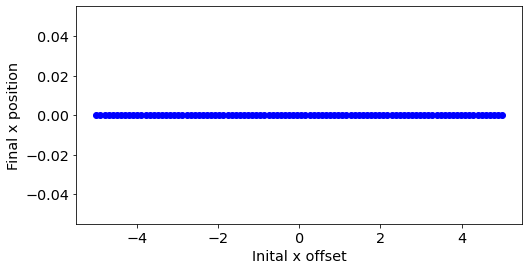

In [11]:
# Let's define a list of several initial offset
x_init = np.linspace(-5, 5, 100) # creates an array of 100 points, linearly spaced form 05 to 5 
x_result = [] # we initiate an empty list to store our final results

for xx in x_init:
    X = np.array([[xx], [0]]) # we redefine our initial vector
    X_fin = DRIFT @ Q @ X # we compute the final coordinates 
    x_result.append(X_fin[0]) # we populate our result list with the x coordinate
    
# And let's plot the final x position as a function of the initial one
plt.figure(figsize=(8,4))
plt.plot(x_init, x_result, 'b-o', lw=2)
plt.xlabel("Inital x offset")
plt.ylabel("Final x position")

We see that no matter the inital offset, the particle is always on the beam axis. **This is the meaning of the focal length!**

---

# Interlude: a small tracking library

---


## Some more convenient functions to model an accelerator

We are going to define some important functions, very useful for the rest of the exercises.

### Modeling of a drift

Let's start with a function that generate a convenient representation of a **drift**. 

In [12]:
def D(L):
    '''Returns the list of a L-long drift'''
    # NB: we return a list with a dict
    # the dict contains the matrix (the transformation)
    # and the element length 
    return [{'matrix':np.array([[1, L],[0, 1]]), 'length':L}] 

# A drift of L=2 m can be generated as:
D(2)

[{'matrix': array([[1, 2],
         [0, 1]]),
  'length': 2}]

The main reason for returning such a `list` with inside a `dictionary` are:

- it will allow us to keep track of the path travelled by the particle (thanks to the `length` dictionary key)
- the element is embedded in a list so to allow for an easy concatenation of elements (e.g. D(1.2) + D(4.3) will produce a list with two elements: one representing a drift of L=1.2 and one of L=4.3 m.

You can find more details about this choice on our ["*Transverse Linear Beam Dynamics Primer using Python*"](./CAS_Optics_Primer.pdf)

In [13]:
# e.g. representation of a beamline made of two drifts of different length:
D(1) + D(2)

[{'matrix': array([[1, 1],
         [0, 1]]),
  'length': 1},
 {'matrix': array([[1, 2],
         [0, 1]]),
  'length': 2}]

> **Note:** this is just **one of many possible implementation** choices.
> One could think of different structures and ways to model a beamline.
> The scope of this course is not to give you a high-efficency and optimised tracking code, 
> but to **help you to understand** the basics of the underlying **accelerator physics**.

### Modeling of a quadrupole

In [14]:
def Q(f):
    '''Returns the list of a quadrupole with focal length f'''
    # NB: we return a list with a dict
    # the dict contains the matrix (the transformation)
    # and the element length 
    return [{'matrix':np.array([[1, 0],[-1/f, 1]]), 'length':0}]

# e.g. representation of a beamline made of one drift followed by one quadrupole:
D(1) + Q(2)

[{'matrix': array([[1, 1],
         [0, 1]]),
  'length': 1},
 {'matrix': array([[ 1. ,  0. ],
         [-0.5,  1. ]]),
  'length': 0}]

### From a list of elements - or beamline - to an equivalent single element

Given our choice of beamline strcuture, i.e. a `list` of **elements**, each modeled by a `dictionary` with some properties, we can define a useful function to compute the *equivalent* matrix (actually an *equivalent* **element** represented by a `dictionary`) of a whole beamline made of several **elements**:

In [15]:
def getEquivalentElement(beamline):
    '''Returns the equivalent single element of a beamline'''
    # we start from an identity matrix (np.eye)
    # with the same dimension of the matrix of the
    # first element of the beamline
    equivalentElement = np.eye(beamline[0]['matrix'].shape[0])
    length = 0
    # NB: we reverse the order of the beamline ([-1::-1])
    for elements in beamline[-1::-1]:
        # we multiply the matrices 
        equivalentElement = equivalentElement @ elements['matrix']
        # and we add the lengths
        length = length + elements['length']
    # we return the dict with the "usual" keys (matrix and length)
    # as for the definition of the D and Q functions
    return [{'matrix':equivalentElement, 'length':length}]

# e.g. equivalent representation of a beamline made of two drifts of different length:
getEquivalentElement(D(1) + D(2))

[{'matrix': array([[1., 3.],
         [0., 1.]]),
  'length': 3}]

### Tracking particles along a beamline

We can also write a function that "tracks" one, or several particles defined by their initial coordinate, along a beamline:

In [16]:
def transportParticles(x0,beamline,s0=0):
    '''Track the particle(s) x0 along the given beamline. 
    If needed, one can specify an initial longitudinal position s0, otherwise set to 0.
    '''
    coords = [x0]
    s = [s0]
    for elements in beamline:
        coords.append(elements['matrix'] @ coords[-1])
        s.append(s[-1] + elements['length']) 
    coords = np.array(coords).transpose()
    return {'x':  coords[:,0,:], # [particle_idx, s_idx]
            'px': coords[:,1,:], # [particle_idx, s_idx]
            's':  np.array(s), # [s_idx]
            'coords': coords,} # [particle_idx, coord_idx, s_idx]

# e.g. define the intial coordinates for 3 particles all with
#      0 x position, but different angles:
x_0 = [[0,0,0,0],
       [0,1,2,4]]
# and let's transport them throw a lattice made of 2 equally long drifts
#   and see the final x coordinate
transportParticles(x_0, D(1)+D(1))['x'][:, -1]

array([0, 2, 4, 8])

### Exercise 5
Let's consider the beamline from [Exercise 4](#exercise-4), i.e. a quadrupole followed by a drift. Let's set the quadrupole's $f=3$ and again verify that parallel rays cross the axis after a distance $L=f$, but this time **using our newly developed functions**.

Please, make one or more plots to prove it using several particles, i.e. different initial conditions. 

#### SOLUTION 1 - using `getEquivalentElement` function.

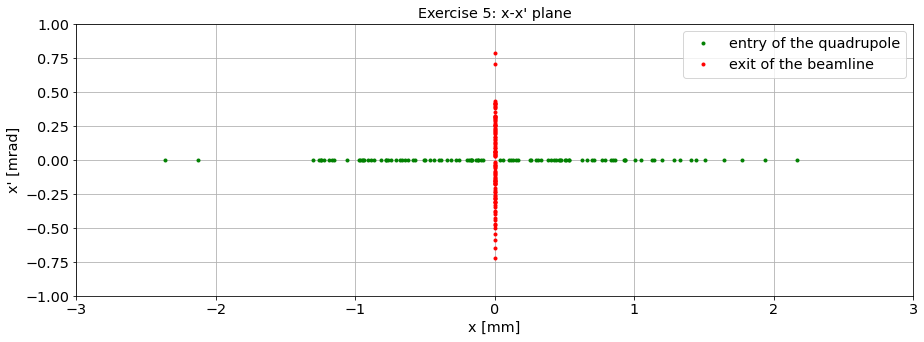

In [17]:
# Particle definition
N = 100
X = np.array([np.random.randn(N)/1000, np.zeros(N)])
# beamline definition
myF = 3 # [m]
beamline = + 2 * D(myF/10) + Q(myF) + 10 * D(myF/10)
output = getEquivalentElement(beamline)[0]['matrix'] @ X
# plotting
plt.plot(X[0,:]*1e3, X[1,:]*1e3,'.g', label='entry of the quadrupole');
plt.plot(output[0,:]*1e3, output[1,:]*1e3,'.r', label='exit of the beamline');
plt.legend()
plt.grid(True)
plt.xlabel('x [mm]')
plt.ylabel("x' [mrad]")
plt.xlim([-3,3])
plt.ylim([-1,1])
plt.title("Exercise 5: x-x' plane");

#### SOLUTION 2 - using `transportParticles` function.

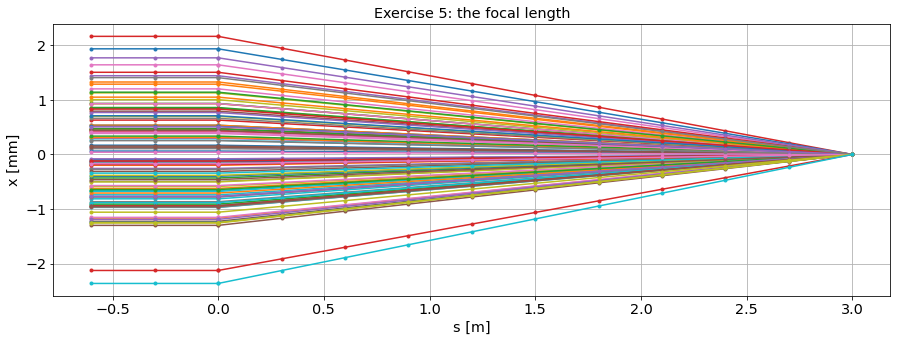

In [18]:
# we the transportParticles function we can se the particle along the line
# this can help to visualize the concept of focal length
output = transportParticles(X, beamline, s0=-2*myF/10)
for my_particle in output['x']:
    plt.plot(output['s'], my_particle*1e3,'.-')
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.title('Exercise 5: the focal length')
plt.grid(True)

Indeed we found back the expected results.

---

# Now is your turn!

Continue by yourself with the following exercises profiting of the library of functions just introduced...

---

### Exercise 6
Recall that the **imaging equation** for a lens is $1/b+1/g=1/f,$ which corresponds to a system of one focusing lens with focal length $f,$ sandwiched between drift spaces with lengths $b$ and $g$. Write a beamline description that corresponds to this system, with $b=3$ m and $g=2$ m. We will later return to it and analyze it.

#### SOLUTION

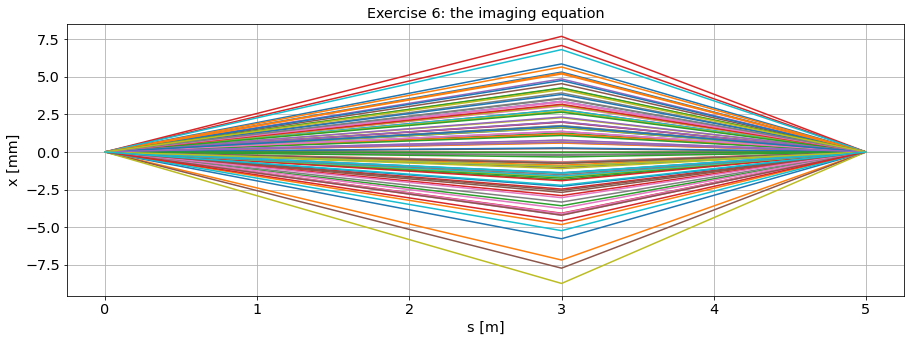

In [19]:
# our parameters
b = 3
g = 2
f = 1/(1/b+1/g)
beamline = D(b) + Q(f) + D(g)
N = 100
X = np.array([np.random.randn(N)*0,np.random.randn(N)*1e-3])
output = transportParticles(X, beamline)
for my_particle in output['x']:
    plt.plot(output['s'], my_particle*1e3)
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.title('Exercise 6: the imaging equation')
plt.grid(True)

### Exercise 7

Define a **FODO beamline** and prepare initial coordinates that describe a particle that is on the optical axis, but has an initial angle $x'$ and plot the position $x$ along the beam line.

**Hint:** A FODO cell is one of the most fundamental lattice topologies. Look back at [Wolfgan's lecture](https://indico.cern.ch/event/1117526/contributions/4978192/):

<p align="center">
<img src=./_img_exercises/slide_fodo.png width="60%">
</p>

#### SOLUTION 
The first part of the exercise is to define a FODO cell structure.  In its simpler version, it consists on two thin quadrupoles of opposite focal length, f, interspaced by two drifts of length L/2 (L is the total length of the cell). We can start the FODO from an arbitrary point inside it. We decided to start describing it from the center of drift.
For the moment we can define arbitrarly the f and L_2 paramenters: we chose 2.5 m and 1 m, respectively.

In [20]:
f = 2.5
L_2 = 1
beamline = 5*D(L_2/10)+Q(f)+10*D(L_2/(10))+Q(-f)+5*D(L_2/10)

Please pay attention that in order to sample more finely the particle trajectory in the drift we split them in pieces of 0.1 m.

We will see in the following cell how, starting from the initial position of the particle, we can transport it along the beam line.
The proper tracking will append to the initial beamlist the transformed coordinate in the trace-space and the incremented s-coordinate.

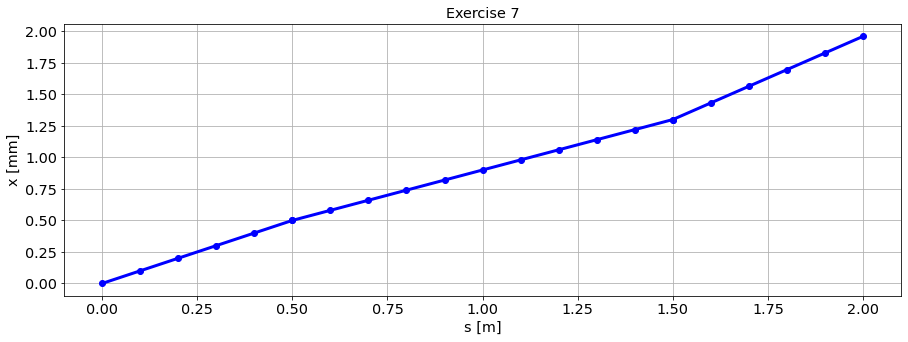

In [21]:
X = np.array([[0],[0.001]])

output = transportParticles(X, beamline)
for my_particle in output['x']:
    plt.plot(output['s'], my_particle*1e3, 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.title('Exercise 7');

### Exercise 8
Plot the angle $x'$ along the beam line.

#### SOLUTION

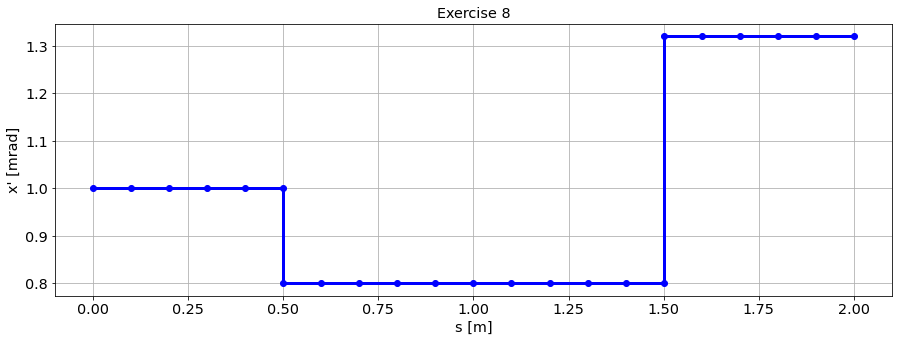

In [22]:
for my_particle in output['px']:
    plt.plot(output['s'], my_particle*1e3, 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel("x' [mrad]");
plt.title('Exercise 8');

### Exercise 9

Plot both the position $x$ and the angle $x'$ through five cells.

#### SOLUTION

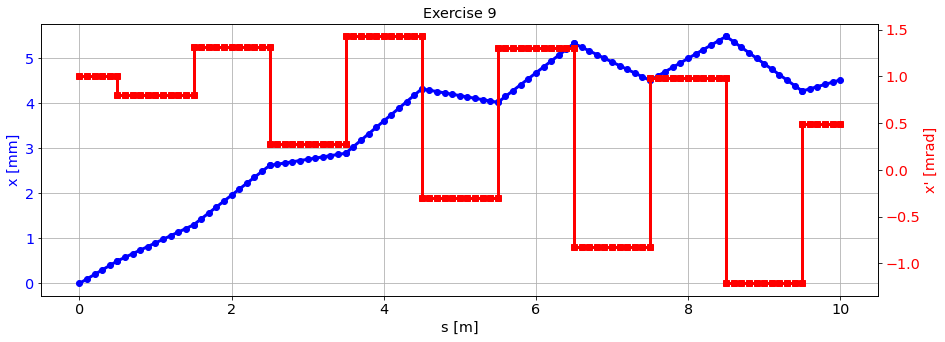

In [23]:
X = np.array([[0],[0.001]])
output = transportParticles(X, 5*beamline)
    
for my_particle in output['x']:
    plt.plot(output['s'], my_particle*1e3, 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.gca().set_ylabel('x [mm]', color='b')
plt.gca().tick_params(axis='y', labelcolor='b')

# instantiate a second axes that shares the same x-axis
ax2 = plt.gca().twinx()  
ax2.set_ylabel("x' [mrad]", color='r')
ax2.tick_params(axis='y', labelcolor='r')
for my_particle in output['px']:
    plt.plot(output['s'], my_particle*1e3, 's-r', lw=3)
plt.title('Exercise 9');

### Exercise 10

Plot the position $x$ through 100 cells, play with different values of the focal length $F$ and explore whether you can make the oscillations grow.

#### SOLUTION

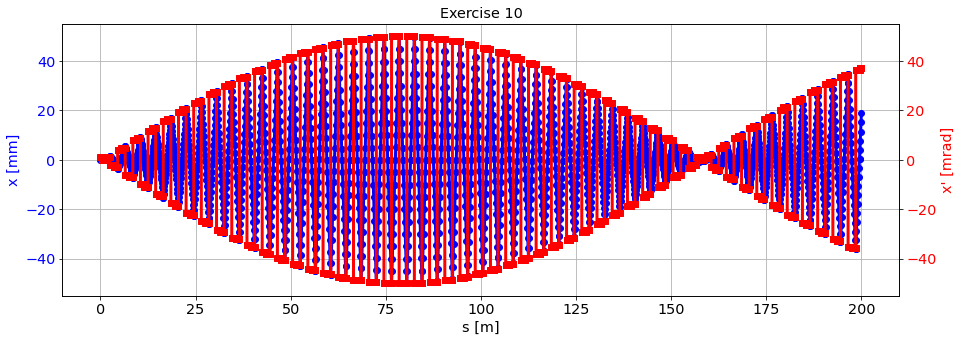

In [24]:
f = .5001
L_2 = 1
beamline = 5*D(L_2/10) + Q(f) + 10*D(L_2/(10)) + Q(-f) + 5*D(L_2/10)
X = np.array([[0],[0.001]])
output = transportParticles(X, 100*beamline)

for my_particle in output['x']:
    plt.plot(output['s'], my_particle*1e3, 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.gca().set_ylabel('x [mm]', color='b')
plt.gca().tick_params(axis='y', labelcolor='b')

# instantiate a second axes that shares the same x-axis
ax2 = plt.gca().twinx()
ax2.set_ylabel("x' [mrad]", color='r')
ax2.tick_params(axis='y', labelcolor='r')
for my_particle in output['px']:
    plt.plot(output['s'], my_particle*1e3, 's-r', lw=3)
plt.title('Exercise 10');

It it important to observe that when the focal length approaches the stability limit (only for $f>L/4$ the machine is stable), then the oscillation start to grow during the transport in the lattice.

Look back at [Wolfgan's lecture](https://indico.cern.ch/event/1117526/contributions/4978192/):

<p align="center">
<img src=./_img_exercises/slide_stability.png width="60%">
</p>

### Exercise 11

Use the beam line for the imaging system you prepared in Exercise 6 and launch a particle with $x_0=0$ and an angle of $x'_0=1\,$mrad at one end. Verify that this particle crosses the center of the beam pipe at the exit of the beam line, provided that $b,g,$ and $f$ satisfy the imaging equation that is shown in Exercise 6.

#### SOLUTION

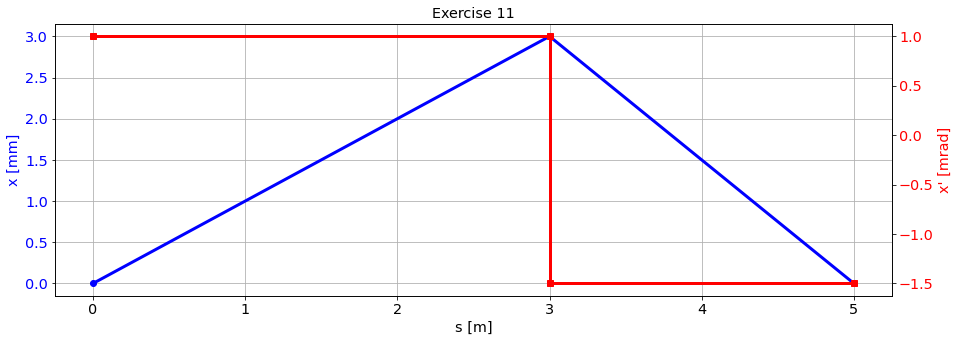

In [25]:
# our parameters
b = 3
g = 2
f = 1/(1/b+1/g)
beamline = D(b) + Q(f) + D(g)

X = np.array([[0],[0.001]])
output = transportParticles(X, beamline)

for my_particle in output['x']:
    plt.plot(output['s'], my_particle*1e3, 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.gca().set_ylabel('x [mm]', color='b')
plt.gca().tick_params(axis='y', labelcolor='b')

# instantiate a second axes that shares the same x-axis
ax2 = plt.gca().twinx()  
ax2.set_ylabel("x' [mrad]", color='r')
ax2.tick_params(axis='y', labelcolor='r')
for my_particle in output['px']:
    plt.plot(output['s'], my_particle*1e3, 's-r', lw=3)
plt.title('Exercise 11');

#### GUIDED SOLUTION

We can do a small animation showing that, moving the position of the quadruple and keeping fulfilled the imaging equation the particle entering with x=0 will exit with x=0.
The animation output is omittend in the pdf version of this document.

In [26]:
from ipywidgets import interactive

def plotIt(b):
    L = 5
    g = L-b
    f = 1/(1/b+1/g)
    beamline = D(b) + Q(f) + D(g)

    X = np.array([[0],[0.001]])
    output = transportParticles(X, beamline)


    for my_particle in output['x']:
        plt.plot(output['s'], my_particle*1e3, 'o-b', lw=3)
    plt.grid(True)
    plt.xlabel('s [m]')
    plt.gca().set_ylabel('x [mm]', color='b')
    plt.gca().tick_params(axis='y', labelcolor='b')
    plt.ylim([-1,4.5])

    # instantiate a second axes that shares the same x-axis
    ax2 = plt.gca().twinx()  
    ax2.set_ylabel("x' [mrad]", color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    for my_particle in output['px']:
        plt.plot(output['s'], my_particle*1e3, 's-r', lw=3)

    plt.title('Exercise 11, animated')
    plt.ylim([-5,5])
    
interactive_plot = interactive(plotIt,b=(2,4,.1),continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '350px'
display(interactive_plot)

interactive(children=(FloatSlider(value=3.0, description='b', max=4.0, min=2.0), Output(layout=Layout(height='…

### Exercise 12

Define an ensemble of 1000 particles with an arbitrary first order ($x0$, $xpo$) and second order momenta($x_{rms}$ and $x'_{rms}$).
Verify the angular divergence of the beam is the one set.

#### SOLUTION

In [27]:
# simple solution
N_particles = 1000
beam = np.random.randn(2, N_particles)
x0 = 0;
xp0 = 1
sigx = 1; 
sigxp = 0.5; 
beam[0,:] = sigx*beam[0,:]+x0
beam[1,:] = sigxp*beam[1,:]+xp0
print(f'Beam mean  x [mm]: {np.mean(beam[0,:])}')
print(f"Beam mean  x' [mrad]: {np.mean(beam[1,:])}")
print(f'Beam rms size [mm]: {np.std(beam[0,:])}')
print(f"Beam rms divergence [mrad]: {np.std(beam[1,:])}")

Beam mean  x [mm]: -0.040496596212860156
Beam mean  x' [mrad]: 0.9652775669713135
Beam rms size [mm]: 0.9974326672860542
Beam rms divergence [mrad]: 0.4933926538041509


**NOTE:** We did not find exactly back the 0.5 value due to the statistical error coming with the finite numbers of particles. We can explore the dependence of the statistical error with on the beam divergence by a numerical simulation.

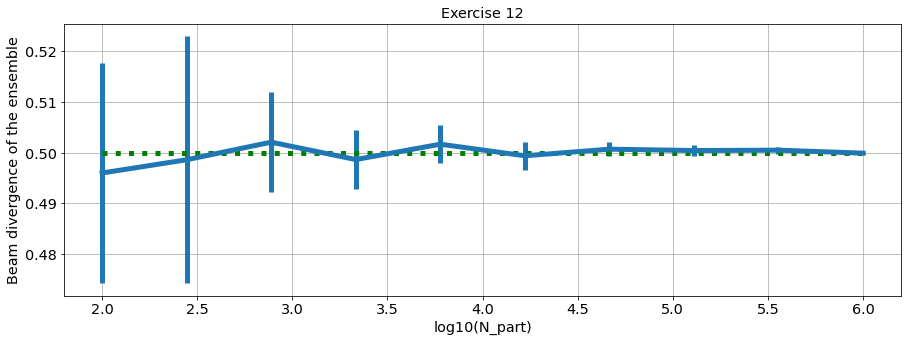

In [28]:
myDivergence = []
myDivergenceStatisticalError = []
Npart_range = np.round(np.logspace(2,6,10))
Npart_range = Npart_range.astype(int)
for Npart in Npart_range:
    aux = []
    for j in range(10):
        beam = np.random.randn(2, Npart)
        x0 = 0;
        xp0 = 1
        sigx = 1; 
        sigxp = 0.5; 
        beam[0,:] = sigx*beam[0,:]+x0
        beam[1,:] = sigxp*beam[1,:]+xp0
        aux.append(np.std(beam[1,:]))
    myDivergence.append(np.mean(aux))
    myDivergenceStatisticalError.append(np.std(aux))
plt.errorbar(np.log10(Npart_range),myDivergence,myDivergenceStatisticalError,lw=5)
plt.plot([2,6],[.5,.5],':g',lw=5)
plt.grid(True)
plt.xlabel('log10(N_part)')
plt.ylabel('Beam divergence of the ensemble')
plt.title('Exercise 12');

> **Depending on the required precision we need to select the convenient number of particles!**

### Exercise 13

1. Transport the beam distribution of Exercise 12 in a drift of length 1 m. Visualise the initial and final distribution.

   **Hint:** One can use the `seaborn` package to nicely see a 2D distribution, e.g.: look at the output of:
   ```python
   import seaborn as sns
   sns.jointplot(x=np.random.randn(1000), y=np.random.randn(1000), kind="hex", color="b")
   ```

2. Test of linearity.  Scale the input vector by 17 times the month of your birthday (e.g. 85 if you are born in May) and verify that the output vector from the matrix multiplication has changed by the same factor.
    
    **Hint:** Be careful with machine precision

3. Now launch 3 particles such that they define a triangle of surface A. Verify that this linear transport preserve the area of the triangle.

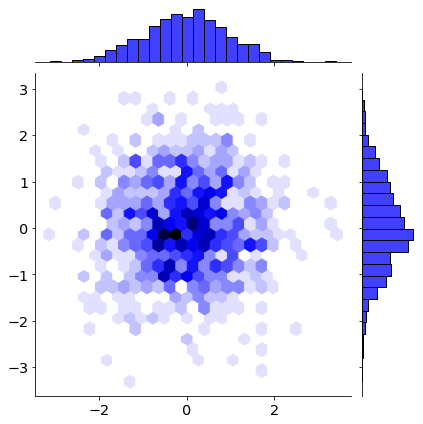

In [29]:
import seaborn as sns
sns.jointplot(x=np.random.randn(1000), y=np.random.randn(1000), kind="hex", color="b")

#### SOLUTION - transport

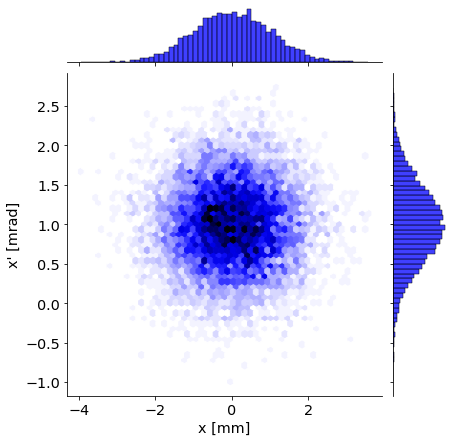

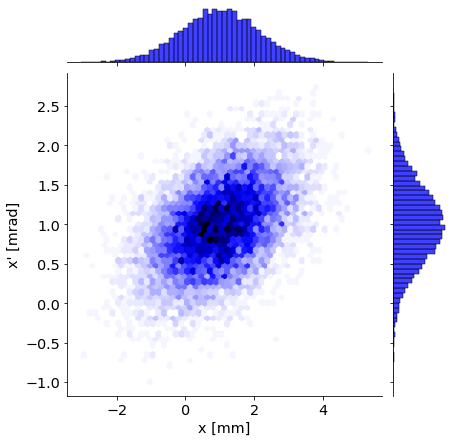

In [30]:
Npart = 10000
beam = np.random.randn(2, Npart)
x0 = 0;
xp0 = 1
sigx = 1; 
sigxp = 0.5; 
beam[0,:] = sigx*beam[0,:]+x0
beam[1,:] = sigxp*beam[1,:]+xp0

beam_after_drift = D(1)[0]['matrix'] @ np.array(beam)

# Before the drift
g = sns.jointplot(x=beam[0,:], y=beam[1,:], kind="hex", color="b")
g.set_axis_labels("x [mm]", "x' [mrad]")
g.savefig('before_drift.pdf')
# After the drift
g = sns.jointplot(x=beam_after_drift[0,:], y=beam_after_drift[1,:],
                  kind="hex", color="b")
g.set_axis_labels("x [mm]", "x' [mrad]")
g.savefig('after_drift.pdf')

#### SOLUTION - test of linearity

In [31]:
# test of linearity
month_birthday = 3
v1 = D(1)[0]['matrix']@(17*month_birthday*beam)
v2 = 17*month_birthday*D(1)[0]['matrix']@(beam)

# this might return False due to machine precision rounding:
print(np.array_equal(v1,v2))
# let's compare at the level of 10 times epsilon, times the scaling factor used for the test
print(np.max(np.abs(v1-v2)) < 10*17*month_birthday*np.finfo(v1.dtype).eps)

False
True


#### SOLUTION - area preservation

Now let us consider three points of the distributions and let us verify that the area of the triangle before and after the transoformation is preserved.
**IMPORTANT**: the area preservation is a condition stronger than the linearity. It is possible only for special matrices, the so-called symplectic matrices.
A $2\times2$ matrix is symplectic if and only if its determinant is one.

In [32]:
# this is the formula of the area of a triangle
from numpy.linalg import norm
def area(a, b, c) :
    '''a,b,c are the phase-space coordinates of three particles'''
    return 0.5 * norm( np.cross( b-a, c-a ) )

In [33]:
# we take the first three particles in the beam (arbitrary choise)
print(f"Before transport {area(beam[:,0],beam[:,1],beam[:,2])}")
print(f"After transport {area(beam_after_drift[:,0],beam_after_drift[:,1],beam_after_drift[:,2])}")

Before transport 0.3449835590404361
After transport 0.34498355904043615


We can visualise this in a plot:

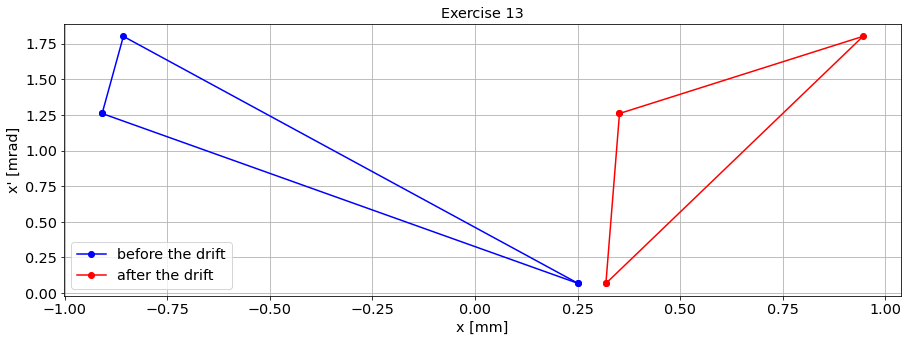

In [34]:
#first triagle
plt.plot(beam[:,:3][0],beam[:,:3][1],'o-b')
plt.plot(beam[:,[2,0]][0],beam[:,[2,0]][1],'o-b', label='before the drift')

#second triagle
plt.plot(beam_after_drift[:,:3][0],beam_after_drift[:,:3][1],'o-r')
plt.plot(beam_after_drift[:,[2,0]][0],beam_after_drift[:,[2,0]][1],'o-r',label='after the drift')

plt.legend()
plt.xlabel('x [mm]')
plt.ylabel("x' [mrad]")
plt.grid(True)
plt.title('Exercise 13');

### Exercise 14
Using the 5 FODO cells of Exercise 9, trasport the beam of Exercise 13 and plot its rms size and divergence along the line.

#### SOLUTION

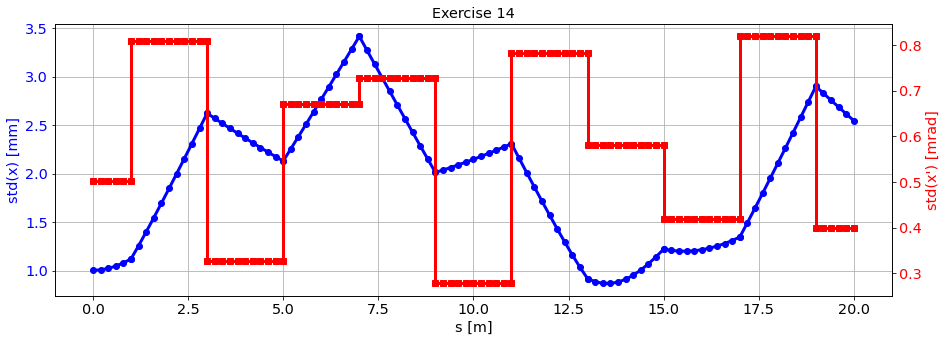

In [35]:
#prepare the optics
f = 2.5
L_2 = 2
fodo_lattice = 5*D(L_2/10)+Q(-f)+10*D(L_2/10)+Q(f)+5*D(L_2/10)

#prepare the beam
Npart = 10000
beam = np.random.randn(2, Npart)
x0 = 0;
xp0 = 1e-3
sigx = 1e-3; 
sigxp = 0.5e-3; 
beam[0,:] = sigx*beam[0,:]+x0
beam[1,:] = sigxp*beam[1,:]+xp0

output = transportParticles(beam, 5*fodo_lattice)

plt.plot(output['s'], np.std(output['x'],0)*1e3, 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.gca().set_ylabel('std(x) [mm]', color='b')
plt.gca().tick_params(axis='y', labelcolor='b')

ax2 = plt.gca().twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel("std(x') [mrad]", color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.plot(output['s'], np.std(output['px'],0)*1e3, 's-r', lw=3)
plt.savefig('exercise14.pdf')

plt.title('Exercise 14');

### Exercise 15

Starting from Exercise 14, what happens if you (a) increase or (b) reduce by a factor 2 the initial beam size and divergence (sigxp)?

#### SOLUTIONS

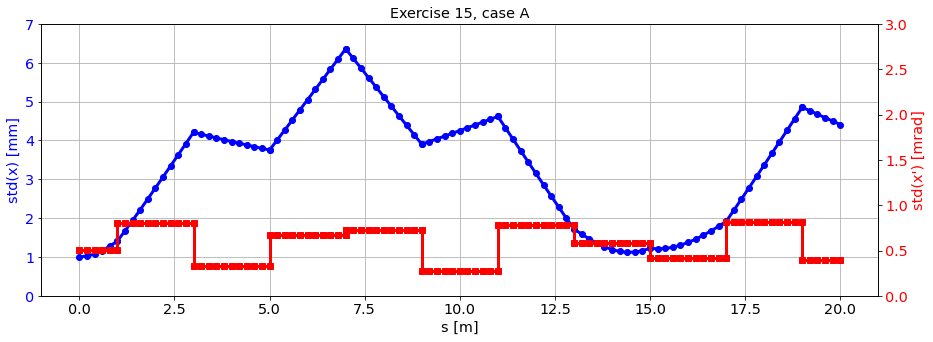

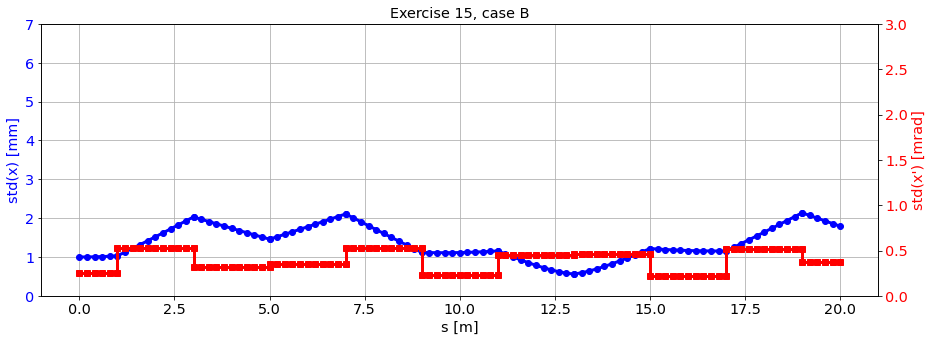

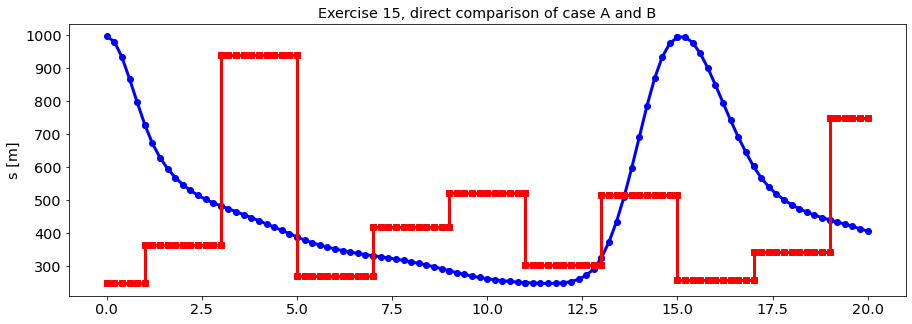

In [36]:
# Case A
f = 2.5
L_2 = 2
fodo_lattice = 5*D(L_2/10)+Q(-f)+10*D(L_2/10)+Q(f)+5*D(L_2/10)

#prepare the beam
Npart = 10000
beam = np.random.randn(2, Npart)
x0 = 0;
xp0 = 1e-3
sigx = 1e-3; 
sigxp = 0.5e-3*2; 
beam[0,:] = sigx*beam[0,:]+x0
beam[1,:] = sigxp*beam[1,:]+xp0

output_a = transportParticles(beam, 5*fodo_lattice)

plt.plot(output_a['s'], np.std(output_a['x'],0)*1e3, 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.gca().set_ylabel('std(x) [mm]', color='b')
plt.gca().tick_params(axis='y', labelcolor='b')
plt.ylim(0,7)

ax2 = plt.gca().twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel("std(x') [mrad]", color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.plot(output['s'], np.std(output['px'],0)*1e3, 's-r', lw=3)
plt.ylim([0,3])
plt.title('Exercise 15, case A');

# Case B
plt.figure()
#prepare the beam
Npart = 100000
beam = np.random.randn(2, Npart)
x0 = 0
xp0 = 1
sigx = 1 
sigxp = 0.5/2 
beam[0,:] = sigx*beam[0,:]+x0
beam[1,:] = sigxp*beam[1,:]+xp0

output_b = transportParticles(beam, 5*fodo_lattice)

plt.plot(output_b['s'], np.std(output_b['x'],0), 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.gca().set_ylabel('std(x) [mm]', color='b')
plt.gca().tick_params(axis='y', labelcolor='b')
plt.ylim(0,7)

ax2 = plt.gca().twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel("std(x') [mrad]", color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.plot(output_b['s'], np.std(output_b['px'],0), 's-r', lw=3)
plt.ylim([0,3])
plt.title('Exercise 15, case B');

# direct comparison
plt.figure()
plt.plot(output_b['s'], np.std(output_b['x'],0)/np.std(output_a['x'],0), 'o-b', lw=3)
plt.plot(output_b['s'], np.std(output_b['px'],0)/np.std(output_a['px'],0), 's-r', lw=3)
plt.ylabel("Ratio")
plt.ylabel("s [m]")
plt.title('Exercise 15, direct comparison of case A and B');

It very important to note that the **divergence of CASE A and CASE B are not proportional**. So as for the single particle position and angle along the machine is proportional (linearity) to the initial conditions, the statistical quantities describing the beam (beam size and beam divergence) only if you are varying **both** beam size and divergence by the same factor.

### Exercise 16

Using Equation 7 of our [Primer](./CAS_Optics_Primer.pdf):

\begin{equation}\label{eq:prop}
\vec X(s_2) =  R\, \vec X(s_1)
\qquad\mathrm{and}\qquad
\sigma(s_2) = R\, \sigma(s_1)\, R^t\, ,
\end{equation}

display (a) the average position of the particles along the beam line. Likewise, (b) display the angular divergence. Compare with the result you found in Exercise 14.

#### SOLUTIONS

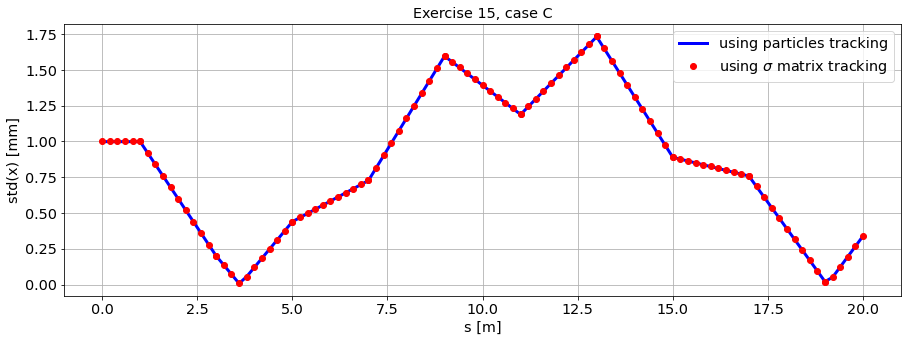

In [37]:
#lattice
f = 2.5
L_2 = 2
fodo_lattice= 5*D(L_2/10) + Q(f) + 10*D(L_2/10) + Q(-f) + 5*D(L_2/10)

#prepare the beam
Npart = 10000
beam0 = np.random.randn(2, Npart)
x0 = 0
xp0 = 1
sigx = 1 
sigxp = 0.5e-3/2 
beam0[0,:] = sigx*beam0[0,:] + x0
beam0[1,:] = sigxp*beam0[1,:] + xp0
beamlist = [(beam0,0)]

#prepare the sigma matrix
sigma0 = np.array([[sigx**2, 0], [0, sigxp**2]])
output_a = transportParticles(beam0, 5*fodo_lattice)


def transportSigmas(sigma, beamline):
    '''Transport the sigma matrix along the beamline'''
    coords = [sigma]
    s = [0]
    for elements in beamline:
        coords.append(elements['matrix'] @ coords[-1] @ elements['matrix'].transpose())
        s.append(s[-1] + elements['length']) 
    coords = np.array(coords).transpose()
    return {'sigma11': coords[0][0],
            'sigma12': coords[0][1],
            'sigma21': coords[1][0], # equal to sigma12
            'sigma22': coords[1][1],
            's':  np.array(s),
            'coords': coords,}

output_b = transportSigmas(sigma0, 5*fodo_lattice)

plt.plot(output_a['s'], np.std(output_a['x'],0), '-b', lw=3, label='using particles tracking')

plt.plot(output_b['s'], np.sqrt(output_b['sigma11']), 'or', lw=3, label='using $\sigma$ matrix tracking')
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('std(x) [mm]')
plt.legend()

# For saving the figure
plt.savefig('exercise_15.pdf')
plt.title('Exercise 15, case C');

It is important to observe that the result of from the particle tracking and the sigma matrix tracking are equivalent. The small deviation is due to the statistical noise of the ensemble (it can be reduced by increasing the numebr of particles).
Clearly the sigma matrix tracking is computationally cheaper than the particle tracking (if Npart>>1).

### Exercise 17
Can you find an initial beam matrix sigma0 that reproduces itself at the end of the beam line? 

**Hint**: Try to proceed by **try and error** and/or **recall** [Wolfgan's lecture](https://indico.cern.ch/event/1117526/contributions/4978192/):

<p align="center">
<img src=./_img_exercises/slide_fodo_periodic.png width="60%">
</p>

#### SOLUTION 1

This problem is not so simple. One could proceed with try and error. But there are three parameters to fix so it can be quite cumbersome... We can still try with an animated plot.

In [38]:
# A first version:

#lattice
f = 2.5
L_2 = 2
fodo_lattice = 5*D(L_2/10) + Q(f) + 10*D(L_2/10) + Q(-f) + 5*D(L_2/10)

def plotIt(sigma11, sigma22, sigma12):
    #prepare the sigma matrix
    sigma0 = np.array([[sigma11, sigma12 ],[sigma12, sigma22]])

    output_b = transportSigmas(sigma0, 5*fodo_lattice)
    plt.figure(figsize=(15,6))
    plt.subplot(311)
    plt.plot(output_b['s'], np.sqrt(output_b['sigma11']), '-b', lw=3)
    plt.ylabel('std(x)')
    plt.grid(True)
    plt.subplot(312)
    plt.plot(output_b['s'], np.sqrt(output_b['sigma22']), '-r', lw=3)
    plt.ylabel('std(x\')')
    plt.grid(True)
    plt.subplot(313)    
    plt.plot(output_b['s'], output_b['sigma12'], '-k', lw=3)
    plt.ylabel('sigma12')
    plt.grid(True)
    
interactive_plot = interactive(plotIt,sigma11=(10,20,.1),sigma22=(0,4,.1),sigma12=(-5,5,.1),continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=15.0, description='sigma11', max=20.0, min=10.0), FloatSlider(value=2.…

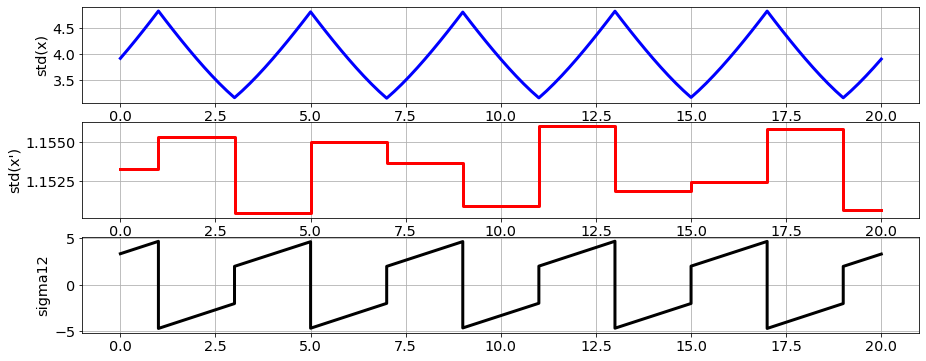

In [39]:
# approximate solution found by hand:
plotIt(15.37, 1.33, 3.34)

#### SOLUTION 2

To simplify the problem, we need to start the lattice at the center of a quadrupole, so sigma12 is zero by construction.
We can then proceed again by try and error...

In [40]:
f = 2.5
L_2 = 2

# same structure, but starting the fodo cell from the center of a quadrupole:
fodo_lattice = Q(2*f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/10) + Q(2*f)
    
interactive_plot = interactive(plotIt,sigma11=(0,25,.1),sigma22=(0,4,.1),sigma12=(-2,2,.1),continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=12.0, description='sigma11', max=25.0), FloatSlider(value=2.0, descrip…

... or use the learned during [Wolfgan's lecture](https://indico.cern.ch/event/1117526/contributions/4978192/) for this particular configuration:

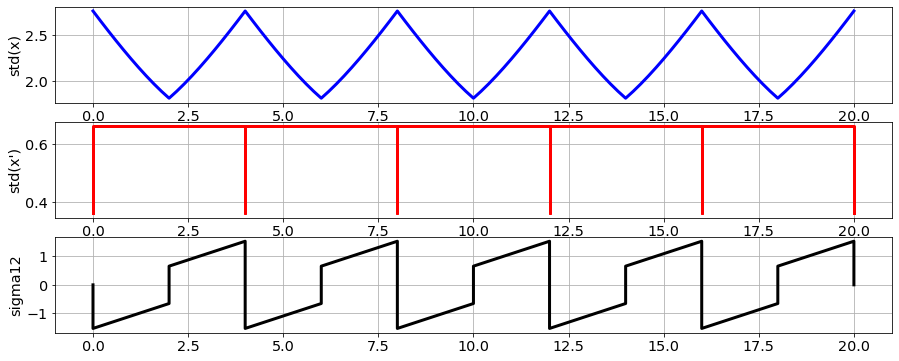

In [41]:
# get the one turn matrix:
fodo_lattice_reduced = getEquivalentElement(fodo_lattice)
# extract the matched initial conditions
sigma11 = fodo_lattice_reduced[0]['matrix'][0,1]/np.sqrt(1-(fodo_lattice_reduced[0]['matrix'][0,0])**2)
sigma22 = 1/sigma11
# plot the solution
plotIt(sigma11, sigma22, 0)

### Exercise 18
Explore different initial coordinate and compare the phase-space plots you obtain.

#### SOLUTIONS
For plotting the trace space evolution of a particle we need to observe it turn-after-turn. The natural way to do that is to compress the beam line (in general composed by more than one element) in a single transformation: the one-turn-matrix, which can be computed using the `getEquivalentElement` function previously introduced.

In [42]:
f = 2.5
L_2 = 2
fodo_lattice = 5*D(L_2/10) + Q(f) + 10*D(L_2/10) + Q(-f) + 5*D(L_2/10)
OTM = getEquivalentElement(fodo_lattice)
def plotIt(x, xp):
    particle = [[x],[xp]]
    output = transportParticles(particle,100*OTM)
    plt.scatter(output['x'], output['px'], c = output['s']/(L_2*2))
    #plt.plot(beamlist[0][0][0],beamlist[0][0][1],'xr',ms=20)
    cb=plt.colorbar()
    cb.set_label('Turns')
    plt.xlabel('x [mm]')
    plt.ylabel("x' [mrad]")
    plt.xlim(-13,13)
    plt.ylim(-5,5)
    plt.grid(True)
    

interactive_plot = interactive(plotIt,x=(-2,2,.1),xp=(-2,2,.1),continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='x', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…

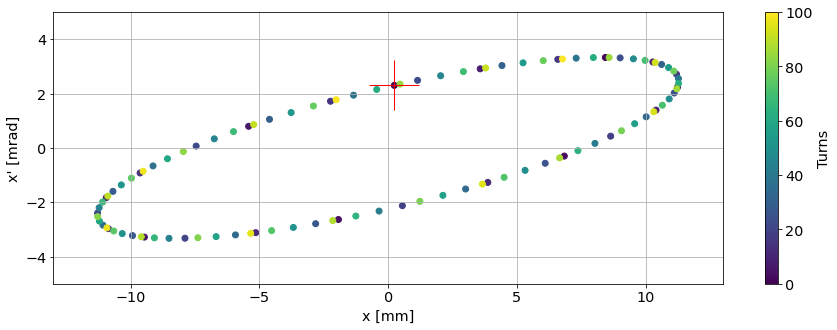

In [43]:
# for saving the figure
x =.24
px = 2.3
plotIt(x, px)
plt.plot(x, px,'+r', ms=50)
plt.savefig('exercise_18.pdf')

### Exercise 19
Plot the position of the particle vs the number of turns. What do you observe?

#### SOLUTION

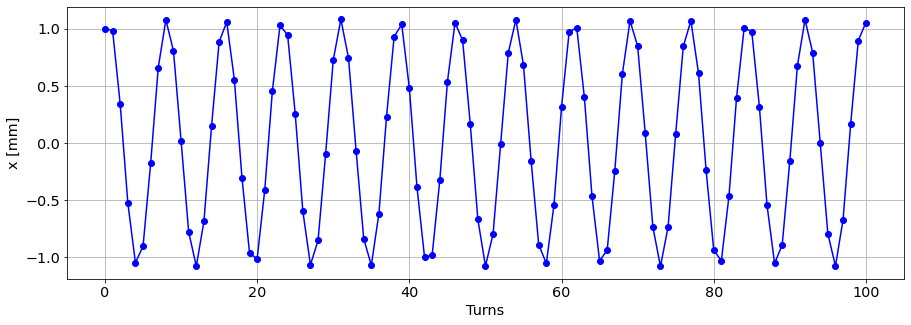

In [44]:
f = 2.5
L_2 = 2
fodo_lattice = 5*D(L_2/10) + Q(f) + 10*D(L_2/10) + Q(-f) + 5*D(L_2/10)
OTM = getEquivalentElement(fodo_lattice)
particle = [[1],[.3]]
output = transportParticles(particle,100*OTM)

plt.plot(output['s']/(L_2*2), output['x'][0] ,'o-b')
plt.xlabel('Turns')
plt.ylabel('x [mm]')
plt.grid(True)

We clearly see a betatronic oscillation. And this is true also for x' (se below, and not the different amplitude and phase).

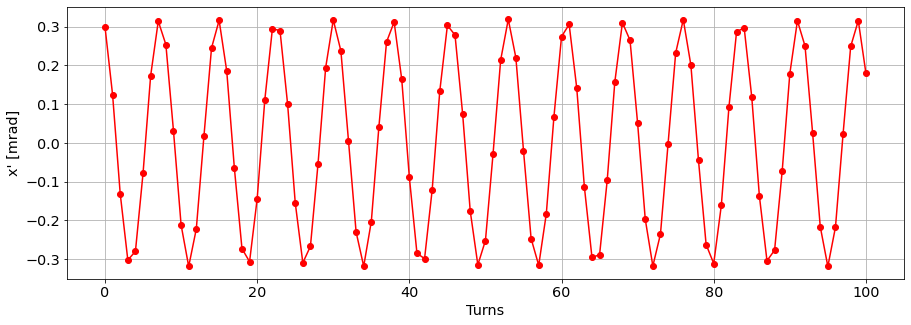

In [45]:
plt.plot(output['s']/(L_2*2), output['px'][0] ,'o-r')
plt.xlabel('Turns')
plt.ylabel("x' [mrad]")
plt.grid(True)

### Exercise 20
In the definition of FODO of the previous exercise, reverse the polarity of both quadrupoles and prepare a phase-space plot. How does it differ from the one in Exercise 18?

#### SOLUTION

In [46]:
f = -2.5
L_2 = 2
fodo_lattice = 5*D(L_2/10) + Q(f) + 10*D(L_2/10) + Q(-f) + 5*D(L_2/10)
OTM = getEquivalentElement(fodo_lattice)
def plotIt(x, xp):
    particle = [[x],[xp]]
    output = transportParticles(particle,100*OTM)
    plt.scatter(output['x'], output['px'], c = output['s']/(L_2*2))
    #plt.plot(beamlist[0][0][0],beamlist[0][0][1],'xr',ms=20)
    cb=plt.colorbar()
    cb.set_label('Turns')
    plt.xlabel('x [mm]')
    plt.ylabel("x' [mrad]")
    plt.xlim(-13,13)
    plt.ylim(-5,5)
    plt.grid(True)

interactive_plot = interactive(plotIt,x=(-2,2,.1),xp=(-2,2,.1),continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='x', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…

As you can see now the ellipse tilt is inverted.

### Exercise 21
From Exercise 20, change the starting point of the lattice at the center of the focusing quadrupole.

**Hint**: split the focusing quadrupole in two focusing quadrupole with double focal length and place them at the start and at the end of the lattice.

#### SOLUTION

In [47]:
f = 2.5
L_2 = 2
fodo_lattice = Q(2*f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/(10)) + Q(2*f)
OTM = getEquivalentElement(fodo_lattice)

def plotIt(x, xp):
    particle = [[x],[xp]]
    output = transportParticles(particle,100*OTM)
    plt.scatter(output['x'], output['px'], c = output['s']/(L_2*2))
    cb = plt.colorbar()
    cb.set_label('Turns')
    plt.xlabel('x [mm]')
    plt.ylabel("x' [mrad]")
    plt.xlim(-13,13)
    plt.ylim(-5,5)
    plt.grid(True)

interactive_plot = interactive(plotIt,x=(-2,2,.1),xp=(-2,2,.1),continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='x', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…

The ellipse is not tilted anymore.

### Exercise 22
Find the range of focal lengths $f$ for which the FODO cells permit stable oscillations.

#### SOLUTION
To solve this exercise we need to compute the phase advance and initial optics functions associated to a OTM rotation. To do that we define the following function.

In [48]:
def twiss(beamline):
    '''Returns the Q, and the Twiss parameters beta, alpha, gamma of the beamline'''
    OTM = getEquivalentElement(beamline)
    R = OTM[0]['matrix']
    mu = np.arccos(0.5*(R[0,0]+R[1,1]))
    if (R[0,1]<0): 
        mu = 2*np.pi-mu;
    Q = mu/(2*np.pi)
    beta = R[0,1]/np.sin(mu)
    alpha = (0.5*(R[0,0]-R[1,1]))/np.sin(mu)
    gamma = (1+alpha**2)/beta
    return Q, beta, alpha, gamma

In [49]:
f = 1
L_2 = 2
fodo_lattice = Q(2*f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/10) + Q(2*f)
output=twiss(fodo_lattice)
print(f'''
Q = {output[0]}
beta = {output[1]}
alpha = {output[2]}
gamma = {output[3]}
''')


Q = 0.49999999419080615
beta = 219176631.31217423
alpha = 7.604216954454841e-09
gamma = 4.562530202299239e-09



The stability condition is satisfied if (only 1D case), the trace of the matrix is smaller than 2 (for the H and V case). For a FODO this can be done analytically. But in this exercise we will follow a numerical approach.

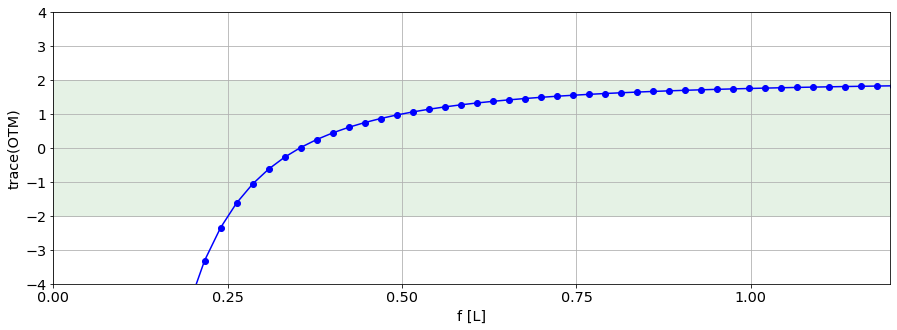

In [50]:
def myOTM_trace(f):
    L_2 = 2
    fodo_lattice = Q(2*f)+10*D(L_2/10)+Q(-f)+10*D(L_2/(10))+Q(2*f)
    OTM = getEquivalentElement(fodo_lattice)
    return np.trace(OTM[0]['matrix'])

def setShadedRegion(ax,color='g' ,xLimit=[0,1], yLimit='FullRange',alpha=.1):
    """
    setShadedRegion(ax,color='g' ,xLimit=[0,1],alpha=.1)
    ax: plot axis to use
    color: color of the shaded region
    xLimit: vector with two scalars, the start and the end point
    alpha: transparency settings
    yLimit: if set to "FullRange" shaded the entire plot in the y direction
    If you want to specify an intervall, please enter a two scalar vector as xLimit
    """
    if yLimit == 'FullRange':
        aux = ax.get_ylim()
        plt.gca().fill_between(xLimit, [aux[0],aux[0]],  [aux[1],aux[1]],color=color, alpha=alpha)
        ax.set_ylim(aux)
    else:
        plt.gca().fill_between(xLimit, 
                    [yLimit[0],yLimit[0]],  [yLimit[1],yLimit[1]],color=color, alpha=alpha)
        
f_range = np.linspace(.5,5)
plt.plot(f_range/(L_2*2), [myOTM_trace(f) for f in f_range],'-bo')
plt.xlim([0,1.2])
my_xlim = plt.xlim()
setShadedRegion(plt.gca(),xLimit=my_xlim,yLimit=[-2,2])
plt.ylim(-4,4)
plt.xlim(my_xlim);
plt.xticks([0, .25, .5, .75,1])
plt.xlabel('f [L]')
plt.ylabel('trace(OTM)')
plt.grid(True)

### Exercise 23
Transport the periodic $\sigma$ matrix along the FODO and convince yourself that the $\sigma$ matrix at the end of the FODO is indeed equal to the one at the start, $\sigma_0$.

#### SOLUTION
One has to remeber the definition of the $\sigma$ matrix (for the momement we will consired $\epsilon=1$) and how to transport it. 

Text(0.5, 1.0, 'Exercise 23')

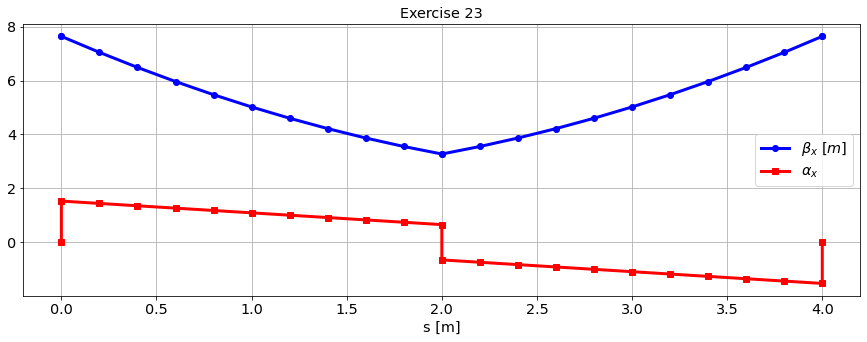

In [51]:
f = 2.5
L_2 = 2
fodo_lattice = Q(2*f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/10) + Q(2*f)
tune, beta, alpha, gamma = twiss(fodo_lattice)
sigma_0 = np.array([[beta, -alpha],[-alpha, gamma]])

output = transportSigmas(sigma_0, fodo_lattice)

plt.plot(output['s'],  output['sigma11'], 'o-b', lw=3, label='$\\beta_x\ [m]$')
plt.plot(output['s'], -output['sigma12'], 's-r', lw=3, label='$\\alpha_x$')
    
plt.grid(True)
plt.legend(loc='best')
plt.xlabel('s [m]')

plt.savefig('exercise_23.pdf')

plt.title('Exercise 23')

### Exercise 24
Write down the numerical values of initial beam matrix $\sigma_0$, then build a beam line made of $15$ consecutive cells by changing the definition of the lattice and then, using $\sigma_0$ with the noted-down numbers, prepare a plot of the beam sizes along the $15$ cells. Is it also periodic?

#### SOLUTION

Text(0.5, 0, 's [m]')

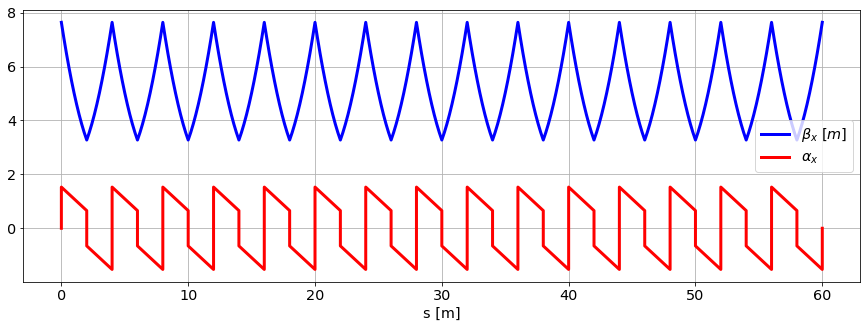

In [52]:
f = 2.5
L_2 = 2
fodo_lattice = Q(2*f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/10) + Q(2*f)
tune, beta, alpha, gamma = twiss(fodo_lattice)
sigma_0 = np.array([[beta, -alpha],[-alpha, gamma]])


output = transportSigmas(sigma_0, 15*fodo_lattice)

plt.plot(output['s'],  output['sigma11'], '-b', lw=3, label='$\\beta_x\ [m]$')
plt.plot(output['s'], -output['sigma12'], '-r', lw=3, label='$\\alpha_x$')
    
plt.grid(True)
plt.legend(loc='best')

plt.xlabel('s [m]')

### Exercise 25
Verify that the OTM has determinant equal to 1.

#### SOLUTION

In [53]:
f = 2.5
L_2 = 2
fodo_lattice = Q(2*f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/10) + Q(2*f)
OTM = getEquivalentElement(fodo_lattice)
print(f'The determinant of the OTM is {np.linalg.det(OTM[0]["matrix"])}.')

The determinant of the OTM is 1.0000000000000002.


### Exercise 26

Multiply $\sigma_0$ from Exercise 24 by 17 and calculate the emittance. Then propagate the $\sigma$ matrix through the beam line from Exercise 24 and verify that the emittance of the sigma matrix after every element is indeed constant and equal to its initial value.

#### SOLUTION

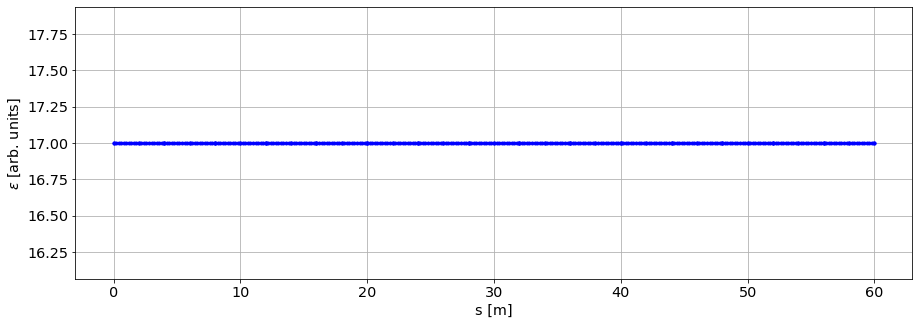

In [54]:
f = 2.5
L_2 = 2
fodo_lattice = Q(2*f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/(10)) + Q(2*f)
tune, beta, alpha, gamma = twiss(fodo_lattice)
sigma_0 = 17*np.array([[beta, -alpha],[-alpha, gamma]])

output = transportSigmas(sigma_0, 15*fodo_lattice)
emittance = np.sqrt(np.linalg.det(output['coords'].transpose()))

plt.plot(output['s'], emittance,'.-b')

plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('$\epsilon$ [arb. units]');

### Exercise 27
Vary $f$ by hand and try to (a) find a value that returns Q= 1/6. (b) Then try to find a value of $f$ that produces a 90 deg phase-advance.  What is the corresponding value of Q?

#### SOLUTION

In [55]:
f = 2
L_2 = 2
fodo_lattice = Q(2*f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/10)+Q(2*f)
tune, beta, alpha, gamma = twiss(fodo_lattice)
print(f'The tune is {tune}.')

The tune is 0.16666666666666677.


In [56]:
f = 2/np.sqrt(2)
L_2 = 2
fodo_lattice = Q(2*f) + 10*D(L_2/10) + Q(-f)+10*D(L_2/10) + Q(2*f)
tune, beta, alpha, gamma = twiss(fodo_lattice)
print(f'The tune is {tune}.')

The tune is 0.24999999999999992.


### Exercise 28

A common task when designing accelerators is matching one section of a beam line
to another one. Here we will assume that the upstream beam line consists of
FODO cells with a $60^o$ phase advance and the downstream beam line of FODO cells 
with a $90^o$ phase advance. These are the cells with the focal length we calculated
in Exercise~27. In between the $60^o$ and $90^o,$ we place a third cell with two
quadrupoles that we will use to match the upstream to the downstream beam line.
To do so, we need to prepare periodic beam matrices sigma60 and sigma90 for the respective sections. Note that sigma90 only depends 
on two parameters: the Twiss parameters $\alpha$ and $\beta,$ and therefore we 
also need two quadrupoles with independently variable focal length to adjust
until the final beam matrix equals sigma90.

Implement the procedure described in the previous paragraph and match of a FODO lattice with $\mu$=60 deg and $\mu$=90 deg.

#### SOLUTION

In [57]:
f = 2
L_2 = 2
fodo_lattice = Q(f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/10)
tune, beta, alpha, gamma = twiss(fodo_lattice)
sigma_60 = np.array([[beta, -alpha],[-alpha, gamma]])

In [58]:
f = 2/np.sqrt(2)
L_2 = 2
fodo_lattice = Q(f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/10)
tune, beta, alpha, gamma = twiss(fodo_lattice)
sigma_90 = np.array([[beta, -alpha],[-alpha, gamma]])
sigma_90

array([[6.82842712, 2.41421356],
       [2.41421356, 1.        ]])

In [59]:
# optimization by hand 
L_2 = 2
f1 = 1.62
f2 = 1.45
fodo_lattice = Q(f1) + 10*D(L_2/10) + Q(-f2) + 10*D(L_2/10)
fodo_lattice_compressed = getEquivalentElement(fodo_lattice)
fodo_lattice_compressed[0]['matrix']@sigma_60@(fodo_lattice_compressed[0]['matrix']).transpose()

array([[6.66672256, 2.45256598],
       [2.45256598, 1.05225316]])

In [60]:
# numerical optimisation using scipy.optimize package
from scipy.optimize import minimize
def penalty_function(f):
    fodo_lattice = Q(f[0]) + 10*D(L_2/10) + Q(-f[1]) + 10*D(L_2/10)
    fodo_lattice_compressed = getEquivalentElement(fodo_lattice)
    M = fodo_lattice_compressed[0]['matrix']@sigma_60@(fodo_lattice_compressed[0]['matrix']).transpose() - sigma_90
    return np.linalg.norm(M)

res = minimize(penalty_function, [1.62, 1.45])
res

      fun: 1.0294826992450796e-08
 hess_inv: array([[ 4.98642707e-09, -1.03490872e-09],
       [-1.03490872e-09,  2.47435887e-09]])
      jac: array([3.05779546, 3.27373282])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 192
      nit: 22
     njev: 60
   status: 2
  success: False
        x: array([1.65681256, 1.38987535])

In [61]:
#sanity check
L_2 = 2
f1 = res['x'][0]
f2 = res['x'][1]
fodo_lattice = Q(f1) + 10*D(L_2/10) + Q(-f2) + 10*D(L_2/10)
fodo_lattice_compressed = getEquivalentElement(fodo_lattice)
fodo_lattice_compressed[0]['matrix']@sigma_60@(fodo_lattice_compressed[0]['matrix']).transpose()-sigma_90

array([[9.62939151e-09, 2.55917376e-09],
       [2.55917509e-09, 3.99417721e-10]])

### Exercise 29 

Introduce as a new element the thick quadrupoles matrices.

**Hint**:  write an external function that returns the corresponding list.

#### SOLUTION

In [62]:
def Qthick(k1, l):
    '''Returns a thick quadrupole element'''
    if k1>0:
        matrix = np.array([[np.cos(np.sqrt(k1)*l), 
                          1/np.sqrt(k1)*np.sin(np.sqrt(k1)*l)],
                          [-np.sqrt(k1)*np.sin(np.sqrt(k1)*l), 
                          np.cos(np.sqrt(k1)*l)]])
    else:
        k1 = -k1;
        matrix = np.array([[np.cosh(np.sqrt(k1)*l),
                          1/np.sqrt(k1)*np.sinh(np.sqrt(k1)*l)],
                          [np.sqrt(k1)*np.sinh(np.sqrt(k1)*l),
                          np.cosh(np.sqrt(k1)*l)]])
    return  [{'matrix': matrix, 'length': l}]

### Exercise 30

Use the beam line from Exercise 27 (60 degrees/cell FODO) and replace the thin quadrupoles by long quadrupoles with a length of 0.2, 0.4, 1.0 m.  Make sure the overall length and the phase advance of the FODO cell remains unchanged. By how much does the periodic beta function at the start of the cell change? Express the change in percent. 

#### SOLUTION

In [63]:
# Thin lens
f = 2
L_2 = 2
fodo_lattice = Q(f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/(10))
tune, beta, alpha, gamma = twiss(fodo_lattice)
beta_thin = beta

# Thick lenses
for l_quad in [.2, .4, 1.0]:
    l_cell = 4 
    l_drift = (l_cell-2*l_quad)/2
    k1 = 1/f/l_quad
    fodo_lattice = Qthick(k1,l_quad)+10*D(l_drift/10)+Qthick(-k1,l_quad)+10*D(l_drift/(10))
    tune, beta, alpha, gamma = twiss(fodo_lattice)
    print(f'With l_quad={l_quad} m we have a relative error if we assume thin lens approximation of {(beta-beta_thin)/beta_thin}!')

With l_quad=0.2 m we have a relative error if we assume thin lens approximation of -0.02066146254119463!
With l_quad=0.4 m we have a relative error if we assume thin lens approximation of -0.03806428935798469!
With l_quad=1.0 m we have a relative error if we assume thin lens approximation of -0.06766354778275335!


### Exercise 31

Implement in a Python function the element corresponding to the weak focusing of a sector bend. 

#### SOLUTION

In [64]:
sin = np.sin
cos = np.cos
B = lambda phi, l: [{'matrix':np.array([[cos(phi),l/phi*sin(phi)],[-sin(phi)/l*phi, cos(phi)]]),  'length': l}]
B(.001,1)

[{'matrix': array([[ 9.99999500e-01,  9.99999833e-01],
         [-9.99999833e-07,  9.99999500e-01]]),
  'length': 1}]

### Exercise 32
Insert 1 m long dipoles in the center of the drift spaces of the FODO cells from Exercise 27 while keeping the length of the cell constant. Investigate deflection angles of φ= 5, 10 and 20 degrees.  Check by how much the periodic beta functions change.  Why do they change?   Can you compensate the phase advance $\mu$ by adjusting the strength or focal lengths of the quadrupoles?

#### SOLUTION 

In [65]:
# Thin lens and no dipoles
f = 2
L_2 = 2
pi = np.pi
fodo_lattice = Q(f) + 10*D(L_2/10) + Q(-f) + 10*D(L_2/(10))
tune, beta, alpha, gamma = twiss(fodo_lattice)
beta_thin = beta

# Thin lens and  dipoles
for phi in np.array([5,10,20])*pi/180:
    f = 2
    l_cell = 4
    l_dipole = 1
    l_drift = (l_cell-l_dipole*2)/4
    fodo_lattice = Q(f) + D(l_drift) + B(phi,l_dipole) + \
                   D(l_drift) + Q(-f) + D(l_drift) + \
                   B(phi,l_dipole) + D(l_drift)
    tune, beta, alpha, gamma = twiss(fodo_lattice)
    print(f'With phi={phi} m we have a relative error of {(beta-beta_thin)/beta_thin}!')

With phi=0.08726646259971647 m we have a relative error of -0.026504367134691145!
With phi=0.17453292519943295 m we have a relative error of -0.09386135560192685!
With phi=0.3490658503988659 m we have a relative error of -0.25835857726299966!


### Exercise 33
Upgrade the software to consistently handle $3\times3$ matrices for drift space, quadrupoles, and sector dipoles.

#### SOLUTION 

In [66]:
def Qthick3(k1, l):
    '''Returns a thick quadrupole element (3x3 case)'''
    if k1>0:
        matrix = np.array([[np.cos(np.sqrt(k1)*l), 1/np.sqrt(k1)*np.sin(np.sqrt(k1)*l), 0],\
                         [-np.sqrt(k1)*np.sin(np.sqrt(k1)*l), np.cos(np.sqrt(k1)*l), 0],\
                        [0,0,1]])
    else:
        k1 = -k1;
        matrix = np.array([[np.cosh(np.sqrt(k1)*l), 1/np.sqrt(k1)*np.sinh(np.sqrt(k1)*l), 0],\
                         [np.sqrt(k1)*np.sinh(np.sqrt(k1)*l), np.cosh(np.sqrt(k1)*l), 0],\
                        [0,0,1]])
    return [{'matrix': matrix, 'length': l}]

In [67]:
# The drift as a sequence of a single tuple
D3 = lambda L: [{'matrix': np.array([[1, L, 0],[0, 1, 0], [0, 0, 1]]), 'length':L}]

# The quadrupole as a sequence of a single tuple
Q3 = lambda f: [{'matrix': np.array([[1, 0, 0],[-1/f, 1,0],[0,0,1]]), 'length':0 }]

# The sector bend
B3 = lambda phi, l: [{'matrix': np.array([[cos(phi),l/phi*sin(phi), l/phi*(1-cos(phi))],\
                              [-sin(phi)/l*phi, cos(phi), sin(phi)],
                             [0,0,1]]), 'length': l}]

def R2beta(R):
    # 2x2 case
    if np.shape(R)[0]==2:
        mu = np.arccos(0.5*(R[0,0]+R[1,1]))
        if (R[0,1]<0): 
            mu = 2*np.pi-mu;
        Q = mu/(2*np.pi)
        beta = R[0,1]/np.sin(mu)
        alpha = (0.5*(R[0,0]-R[1,1]))/np.sin(mu)
        gamma = (1+alpha**2)/beta
        return (Q, beta, alpha, gamma)
    
    # 3x3 case
    if np.shape(R)[0]==3:
        R = R[:3,:3]
        mu = np.arccos(0.5*(R[0,0]+R[1,1]))
        if (R[0,1]<0): 
            mu = 2*np.pi-mu;
        Q = mu/(2*np.pi)
        beta = R[0,1]/np.sin(mu)
        alpha = (0.5*(R[0,0]-R[1,1]))/np.sin(mu)
        gamma = (1+alpha**2)/beta
        return (Q, beta, alpha, gamma)

### Exercise 34
Build a beam line of six FODO cells with a phase advance of 60 degrees/cell (thin quadrupoles are OK to use) and add a sector bending magnet with length 1 m and bending angle $\phi=10$ degrees in the center of each drift. You may have to play with the quadrupole values to make the phase advance close to 60 degrees. But you probably already did this in Exercise 32.

#### SOLUTION

In [68]:
f = 2.26085
l_cell = 4
l_dipole = 1
l_drift = (l_cell-l_dipole*2)/4
phi = 20*pi/360
fodo_lattice = Q3(f) + 3*D3(l_drift/3) + B3(phi,l_dipole) + 3*D3(l_drift/3) + \
               Q3(-f) + 3*D3(l_drift/3) + B3(phi,l_dipole) + 3*D3(l_drift/3)

tune, beta, alpha, gamma = twiss(fodo_lattice)
print(f'''
The tune is: {tune}
The beta is: {beta} m
The alpha is: {alpha} 
The gamma is: {gamma}
''')


The tune is: 0.16666742254599543
The beta is: 6.402756913976354 m
The alpha is: -1.4160065714170231 
The gamma is: 0.4693407309805126



### Exercise 35
Use the starting conditions $(x_0,x_0',\delta)=(0,0,0)$ and plot the position along the beam line. Repeat this for $\delta=10^{-3}$ and for $\delta=3\times 10^{-3}$. Plot all three traces in the same graph. Discuss what you observe and explain.

#### SOLUTION

Text(0, 0.5, 'x [mm]')

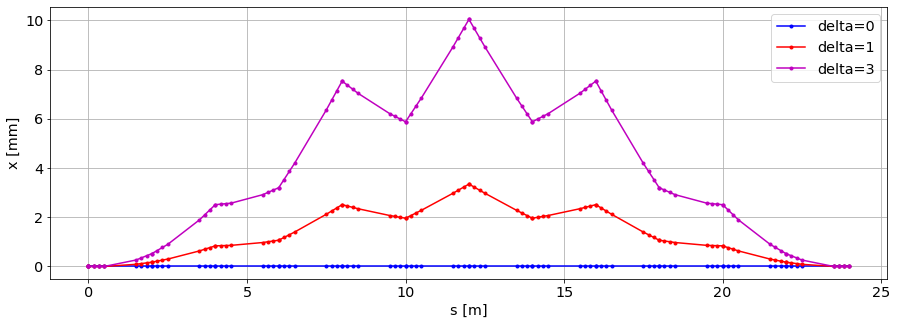

In [69]:
# tracking
for delta,color in zip([0,1, 3],['b','r','m']):
    beam = np.array([[0],[0],[delta]])
    output = transportParticles(beam, 6*fodo_lattice)
    plt.plot(output['s'], output['x'][0], '.-'+color, label=f'delta={delta}')

plt.legend()
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('x [mm]')

### Exercise 36
Work out the transverse components of the periodic beam matrix $\sigma_0$. Assume that the geometrical emittance is $\epsilon_0=10^{-6}$ m rad. Furthermore, assume that the momentum spread $\sigma_0(3,3)=\sigma_p^2$ is zero and plot the beam size along the beam line.

#### SOLUTION

In [70]:
epsilon_0 = 1e-6
sigma_p_2 = 0
sigma_0 = epsilon_0*np.array([[beta, -alpha, 0],[-alpha, gamma,0],[0,0,sigma_p_2]])

Text(0.5, 0, 's [m]')

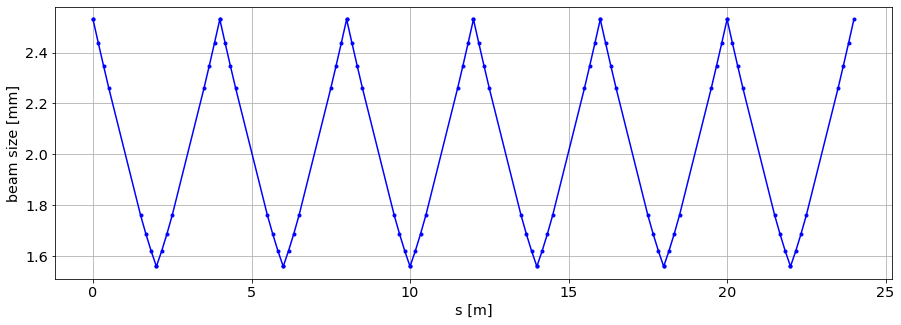

In [71]:
output = transportSigmas(sigma_0, 6*fodo_lattice)
plt.plot(output['s'], np.sqrt(output['sigma11'])*1e3, '.-b')
plt.grid(True)
plt.ylabel('beam size [mm]')
plt.xlabel('s [m]')

### Exercise 37
Plot the beam size for for $\sigma_p^2=10^{-3}$ and for $\sigma_p^2=3\times 10^{-3}$. What happens if you change the phase advance of the cell? Try out by slightly changing the focal lengths.

#### SOLUTION

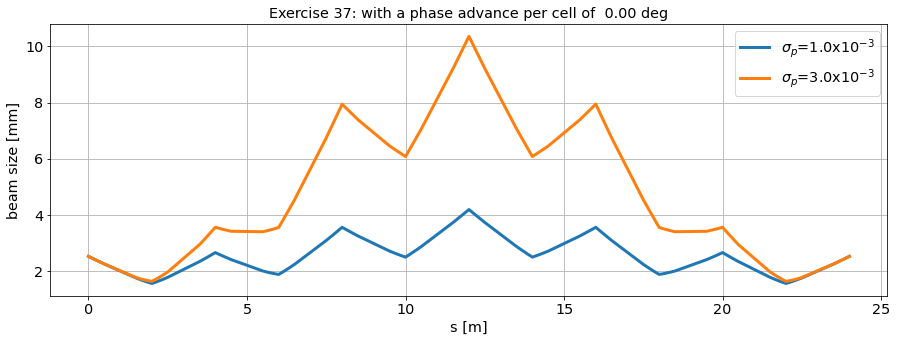

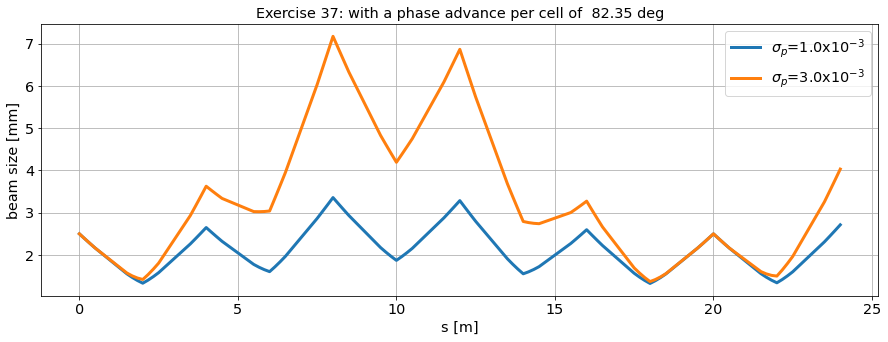

In [72]:
l_cell = 4
l_dipole = 1
l_drift = (l_cell-l_dipole*2)/4
phi = 20*pi/360

for f in [2.26085, 1.8]:
    plt.figure()
    fodo_lattice = Q3(f)+3*D3(l_drift/3)+B3(phi,l_dipole)+3*D3(l_drift/3)+Q3(-f)+3*D3(l_drift/3)+B3(phi,l_dipole)+3*D3(l_drift/3)
    beamline = 6*fodo_lattice
    tune, beta, alpha, gamma = twiss(beamline)
    
    for sigma_p in [1e-3, 3e-3]:
        sigma_p_2 = (sigma_p)**2
        sigma_0 = epsilon_0*np.array([[beta, -alpha, 0],[-alpha, gamma,0],[0,0,sigma_p_2/epsilon_0]])
        output = transportSigmas(sigma_0, 6*fodo_lattice)
        plt.plot(output['s'], np.sqrt(output['sigma11'])*1e3, label= f'$\sigma_p$={sigma_p*1e3}x$10^{{-3}}$', lw=3)

    plt.grid(True)
    plt.ylabel('beam size [mm]')
    plt.xlabel('s [m]')
    plt.title(f'Exercise 37: with a phase advance per cell of {tune*2*180: 3.2f} deg')
    plt.legend(loc='best')

### Exercise 38

Determine the periodic dispersion at the start of the cell. Then plot the dispersion in the cell.

#### SOLUTION

For that we need to solve the problem 

In [73]:
OTM = getEquivalentElement(beamline)
OTM[0]['matrix']

array([[-1.58355116,  6.17981624,  1.05442713],
       [-0.63578962,  1.84968009,  0.48622481],
       [ 0.        ,  0.        ,  1.        ]])

In [74]:
eigenvalues, eigenvectors =np.linalg.eig(OTM[0]['matrix'])

In [75]:
eigenvalues

array([0.13306447+0.99110738j, 0.13306447-0.99110738j,
       1.        +0.j        ])

In [76]:
myDispersion=eigenvectors[:,2]/eigenvectors[2,2]
myDispersion

array([1.21626937+0.j, 0.3378526 +0.j, 1.        +0.j])

In [77]:
# sanity check: one can see that indeeed is a periodic solution!
OTM[0]['matrix'] @ myDispersion

array([1.21626937+0.j, 0.3378526 +0.j, 1.        +0.j])

### Exercise 39
Convert the code to use $4\times4$ matrices, where the third and fourth columns are associated with the vertical plane. 

#### SOLUTION

In [78]:
def Qthick4(k1, l):
    '''Returns a thick quadrupole element (4x4 case)'''
    if k1>0:
        matrix=np.array([[np.cos(np.sqrt(k1)*l), 1/np.sqrt(k1)*np.sin(np.sqrt(k1)*l), 0,0],\
                         [-np.sqrt(k1)*np.sin(np.sqrt(k1)*l), np.cos(np.sqrt(k1)*l), 0, 0],\
                         [0,0,np.cosh(np.sqrt(k1)*l), 1/np.sqrt(k1)*np.sinh(np.sqrt(k1)*l)],\
                         [0,0,np.sqrt(k1)*np.sinh(np.sqrt(k1)*l), np.cosh(np.sqrt(k1)*l)],\
                        ])
    else:
        k1=-k1;
        matrix=np.array([[np.cosh(np.sqrt(k1)*l), 1/np.sqrt(k1)*np.sinh(np.sqrt(k1)*l), 0,0],\
                         [np.sqrt(k1)*np.sinh(np.sqrt(k1)*l), np.cosh(np.sqrt(k1)*l), 0,0],\
                         [0,0,np.cos(np.sqrt(k1)*l), 1/np.sqrt(k1)*np.sin(np.sqrt(k1)*l)],\
                         [0,0,-np.sqrt(k1)*np.sin(np.sqrt(k1)*l), np.cos(np.sqrt(k1)*l)],\
                         ])
    return [{'matrix': matrix, 'length': l}]


# The drift as a sequence of a single tuple
D4 = lambda L: [{'matrix': np.array([[1, L, 0, 0],[0, 1, 0, 0], [0, 0, 1, L], [0, 0, 0, 1]]), 'length': L}]

# The quadrupole as a sequence of a single tuple
Q4 = lambda f: [{'matrix': np.array([[1, 0, 0, 0],[-1/f, 1, 0, 0],[0, 0, 1, 0],[0, 0, 1/f, 1]]), 'length': 0}]

# The sector bend
B4 = lambda phi, l: [{'matrix': np.array([[cos(phi),l/phi*sin(phi), 0, 0],\
                               [-sin(phi)/l*phi, cos(phi), 0, 0],\
                               [0, 0, 1, l],
                               [0, 0, 0, 1]]),'length': l}]

def twiss(beamline):
    '''Returns the Q, and the Twiss parameters beta, alpha, gamma of the beamline'''
    # 2x2 case
    OTM = getEquivalentElement(beamline)
    R = OTM[0]['matrix']
    
    if np.shape(R)[0]<4:
        mu = np.arccos(0.5*(R[0,0]+R[1,1]))
        if (R[0,1]<0): 
            mu = 2*np.pi-mu;
        Q = mu/(2*np.pi)
        beta = R[0,1]/np.sin(mu)
        alpha = (0.5*(R[0,0]-R[1,1]))/np.sin(mu)
        gamma = (1+alpha**2)/beta
        return Q, beta, alpha, gamma

    
    # 4x4 case, we assume uncoupled motion!!!
    if np.shape(R)[0]==4:
        Rx = R[:2,:2]
        mux = np.arccos(0.5*(Rx[0,0]+Rx[1,1]))
        if (Rx[0,1]<0): 
            mux = 2*np.pi-mux;
        Qx = mux/(2*np.pi)
        betax = Rx[0,1]/np.sin(mux)
        alphax = (0.5*(Rx[0,0]-Rx[1,1]))/np.sin(mux)
        gammax = (1+alphax**2)/betax
        
        Ry = R[2:,2:]
        muy = np.arccos(0.5*(Ry[0,0]+Ry[1,1]))
        if (Ry[0,1]<0): 
            muy = 2*np.pi-muy;
        Qy = muy/(2*np.pi)
        betay = Ry[0,1]/np.sin(muy)
        alphay = (0.5*(Ry[0,0]-Ry[1,1]))/np.sin(muy)
        gammay = (1+alphay**2)/betay
        
        return (Qx, betax, alphax, gammax, Qy, betay, alphay, gammay)
    
# Test
f = 2.
l_cell = 4
l_drift = (l_cell)/2
fodo_lattice = Q4(f) + 10*D4(l_drift/10) + Q4(-f) + 10*D4(l_drift/10)
twiss(fodo_lattice)
print(f'''
The tune is: {tune}
The beta is: {beta} m
The alpha is: {alpha} 
The gamma is: {gamma}
''')


The tune is: 0.2287591328904243
The beta is: 6.235264040046442 m
The alpha is: -1.7320177889017894 
The gamma is: 0.641494184589888



### Exercise 40
Start from a single FODO cell with 60 degrees/cell you used earlier. Insert sector bending magnets with a bending angle of $\phi=10\,$degrees in the center of the drift spaces. The bending magnets will spoil the phase advance in one plane. Now you have two phase advances and need to adjust both quadrupoles (by hand to 2 significant figures) such that it really is 60 degrees in both planes.

#### SOLUTION

In [79]:
l_cell = 4
l_dipole = 1
l_drift = (l_cell-l_dipole*2)/4
phi = 10*pi/360

def computeTunes(f_f,f_d):
    fodo_lattice = Q4(f_f) + D4(l_drift) + B4(phi,l_dipole) + D4(l_drift) + Q4(f_d) + D4(l_drift) + B4(phi,l_dipole) + D4(l_drift)
    Qx, betax, alphax, gammax, Qy, betay, alphay, gammay = twiss(fodo_lattice)
    print(f'Qx = {Qx}')
    print(f'Qy = {Qy}')
    print(f'f_f = {f_f}')
    print(f'f_d = {f_d}')

    
interactive_plot = interactive(computeTunes, f_f=(1.9,2.1,.001), f_d=(-2.1,-1.9,.001), continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '100px'
interactive_plot

interactive(children=(FloatSlider(value=2.0, description='f_f', max=2.1, min=1.9, step=0.001), FloatSlider(val…

In [80]:
computeTunes(2.04,-2.012)

Qx = 0.16679597540775903
Qy = 0.16683496767875342
f_f = 2.04
f_d = -2.012


### Exercise 41

Use the result from exercise 40 and adjust the two quadrupoles such that the phase advance in the horizontal plane is 90 degrees, cell, while it remains 60 degrees/cell in the vertical plane. 

#### SOLUTION

In [81]:
interactive_plot = interactive(computeTunes,f_f=(1.,3,.001),f_d=(-3,-1,.001),continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '100px'
interactive_plot

interactive(children=(FloatSlider(value=2.0, description='f_f', max=3.0, min=1.0, step=0.001), FloatSlider(val…

In [82]:
computeTunes(1.491,-1.814)

Qx = 0.25013216769227664
Qy = 0.16677964050295388
f_f = 1.491
f_d = -1.814


### Exercise 42
Prepare a beam line with eight FODO cells without bending magnets and with 60 degrees/cell phase advance in both planes. (a) Prepare the periodic beam  matrix sigma0 (4x4, uncoupled) as the initial beam and plot both beam sizes along the beam line. (b) Use sigma0 as the starting beam, but change the focal length of the second quadrupole by 10\% and plot the beam sizes once again. Discuss you observations.

#### SOLUTION

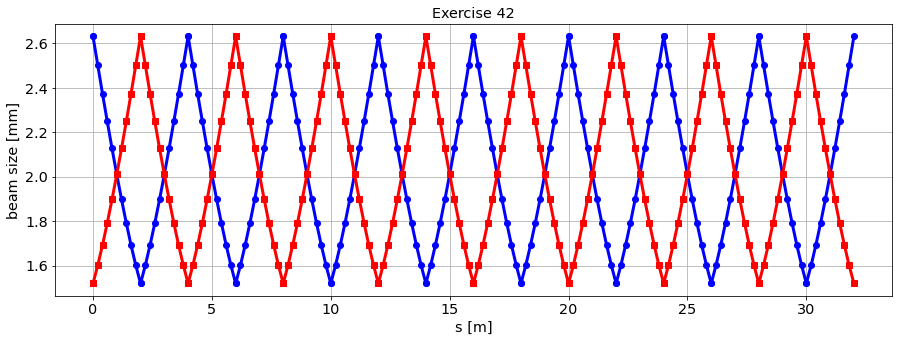

In [83]:
def transportSigmas(sigma, beamline):
    coords = [sigma]
    s = [0]
    for elements in beamline:
        coords.append(elements['matrix'] @ coords[-1] @ elements['matrix'].transpose())
        s.append(s[-1] + elements['length']) 
    coords = np.array(coords).transpose()
    if len(sigma) < 4:
        return {'sigma11': coords[0][0],
                'sigma12': coords[0][1],
                'sigma21': coords[1][0], # equal to sigma12
                'sigma22': coords[1][1],
                's':  np.array(s),
                'coords': coords,}
    elif len(sigma)==4:
        return {'sigma11': coords[0][0],
                'sigma12': coords[0][1],
                'sigma21': coords[1][0], # equal to sigma12
                'sigma22': coords[1][1],
                'sigma33': coords[2][2],
                'sigma34': coords[2][3],
                'sigma43': coords[3][2], # equal to sigma12
                'sigma44': coords[3][3],
                's':  np.array(s),
                'coords': coords,}
        
f = 2.
l_cell = 4
l_drift = (l_cell)/2
fodo_lattice = Q4(f) + 10*D4(l_drift/10) + Q4(-f) + 10*D4(l_drift/10)
beamline = 8*fodo_lattice

Qx, betax, alphax, gammax, Qy, betay, alphay, gammay = twiss(beamline)


epsilon_0 = 1e-6
sigma_0 = epsilon_0*np.array([[betax, -alphax,0, 0],[-alphax, gammax,0,0],
                  [0,0, betay, -alphay],[0,0, -alphay, gammay],
                 ])

output = transportSigmas(sigma_0, beamline)
plt.plot(output['s'], np.sqrt(output['sigma11'])*1e3, 'o-b', lw=3)
plt.plot(output['s'], np.sqrt(output['sigma33'])*1e3, 's-r', lw=3)
plt.grid(True)
plt.ylabel('beam size [mm]')
plt.xlabel('s [m]')
plt.title('Exercise 42');

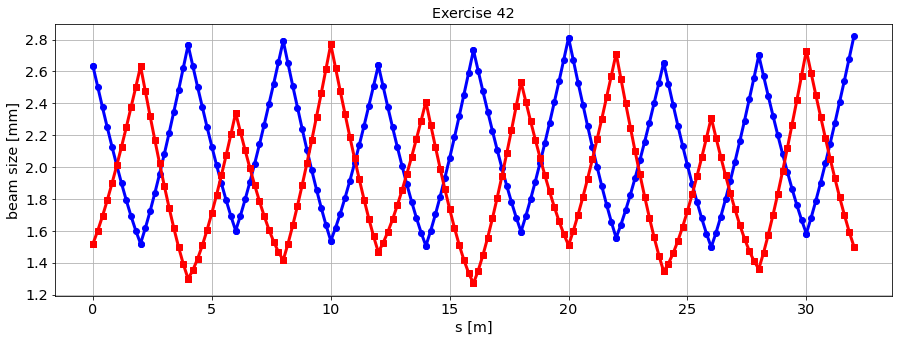

In [84]:
from copy import deepcopy
beamline_new = deepcopy(beamline)
beamline_new[11]['matrix'][1,0] = beamline_new[11]['matrix'][1,0]*1.1
beamline_new[11]['matrix'][3,2] = beamline_new[11]['matrix'][3,2]*1.1

Qx, betax, alphax, gammax, Qy, betay, alphay, gammay = twiss(fodo_lattice)

epsilon_0 = 1e-6
sigma_0 = epsilon_0*np.array([[betax, -alphax,0, 0],[-alphax, gammax,0,0],
                  [0,0, betay, -alphay],[0,0, -alphay, gammay],
                 ])

output = transportSigmas(sigma_0, beamline_new)
plt.plot(output['s'], np.sqrt(output['sigma11'])*1e3, 'o-b', lw=3)
plt.plot(output['s'], np.sqrt(output['sigma33'])*1e3, 's-r', lw=3)
plt.grid(True)
plt.ylabel('beam size [mm]')
plt.xlabel('s [m]')
plt.title('Exercise 42');

### Exercise 43
From the lecture about betatron coupling identify the transfer matrix for a solenoid and write a function that receives the longitudinal magnetic field $B_s$ and the length of the solenoid as input and returns the transfer matrix.  Then extend the simulation code to handle solenoids. Finally, define a beam line where you place the solenoid in the middle of a FODO cell and follow a particle with initial condition $(x_0,x'_0,y_0,y'_0)=(10^{-3}\,\mathrm{m},0,0,0).$ What do you observe? Is the motion confined to the horizontal plane? 

#### SOLUTION
One has to remember that the matrix is
\begin{equation}
M_{\text {SOLENOID}}=\left(\begin{array}{cccc}{C^{2}} & {\frac{1}{K} S C} & {S C} & {\frac{1}{K} S^{2}}\\
{-K S C} & {C^{2}} & {-K S^{2}} & {S C}\\
{-S C} & {-\frac{1}{K} S^{2}} & {C^{2}} & {\frac{1}{K} S C}\\
{K S^{2}} & {-S C} & {-K S C} & {C^{2}}
\end{array}\right)
\end{equation}
where
\begin{equation}
K=\operatorname{sgn}(\mathrm{q}) \frac{B_{s}}{2(B \rho)}
\end{equation}
and
\begin{equation}
\begin{array}{l}{C=\cos K L} \\ {S=\sin K L}\end{array}
\end{equation}

In [85]:
def solenoid(Bs, L, B_rho, q):
    '''Returns the L-long solenoid element with field Bs 
    normalized to B_rho and to the q polarity.'''
    K = np.sign(q)*Bs/B_rho/2
    C = np.cos(K*L)
    S = np.sin(K*L)
    matrix = np.array([[C**2, S*C/K, S*C, S**2/K],
                     [-K*S*C, C**2, -K*S**2, S*C],
                     [-S*C, -S**2/K, C**2, S*C/K],
                     [K*S**2, -S*C, -K*S*C, C**2]])
    return [{'matrix': matrix,'length': L}]

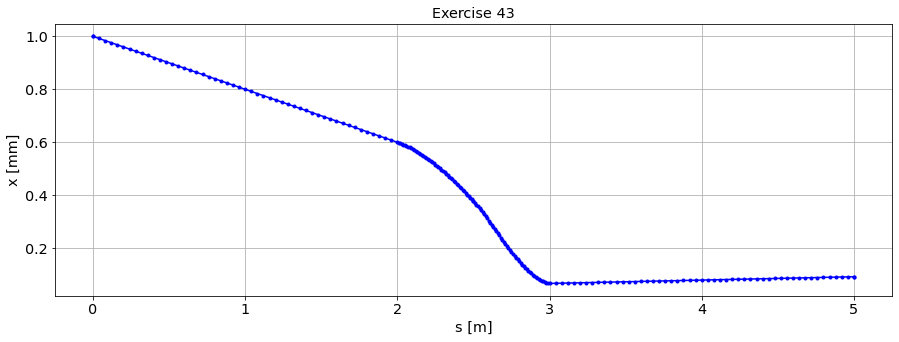

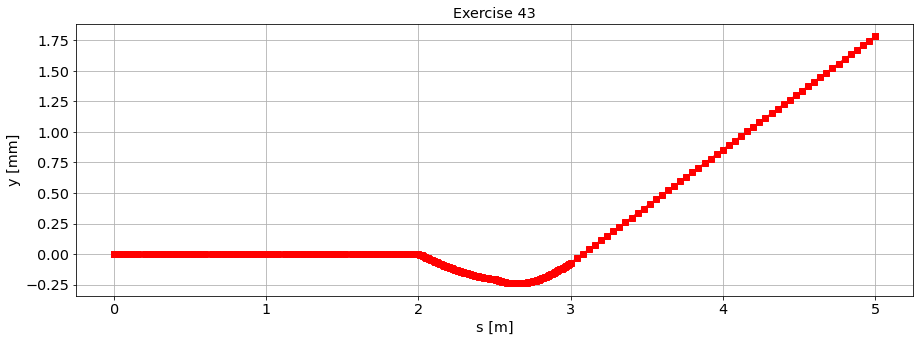

In [86]:
# we need a minor update to the transportParticles
def transportParticles(x0,beamline):
    coords = [x0]
    s = [0]
    for elements in beamline:
        coords.append(elements['matrix'] @ coords[-1])
        s.append(s[-1] + elements['length']) 
    coords = np.array(coords).transpose()
    if len(x0)<4:
        return {'x':  coords[:,0,:],
            'px': coords[:,1,:],
            's':  np.array(s),
            'coords': coords,}
    elif len(x0)==4:
        return {'x':  coords[:,0,:],
            'px': coords[:,1,:],
            'y':  coords[:,2,:],
            'py': coords[:,3,:],
            's':  np.array(s),
            'coords': coords,}

f = 2.5
L_2 = 2
fodo_lattice = Q4(2*f) + 50*D4(L_2/50) + 50*solenoid(.2,.01,.1,1) + Q4(-f) + 50*solenoid(.4,.01,.1,1) + 50*D4(L_2/(50))+Q4(2*f)

beam = np.array([[1e-3],[0],[0],[0]])

output = transportParticles(beam, fodo_lattice)

plt.plot(output['s'], output['x'][0]*1e3,'.-b')
plt.xlabel('s [m]')
plt.ylabel("x [mm]")
plt.grid(True)
plt.title('Exercise 43')

plt.figure()
plt.plot(output['s'], output['y'][0]*1e3,'s-r')
plt.xlabel('s [m]')
plt.ylabel("y [mm]")
plt.grid(True)
plt.title('Exercise 43');

One can clearly see that the motion is coupled between the two transverse planes.

## Well done! You did all exercises!